# CIS 545 Final Project, Spring 2022
Group 15: Jia Xu, Yuluan Cao, Yuqin Zhang

#$\text{A Silent Killer in India: Air Pollution}$




---

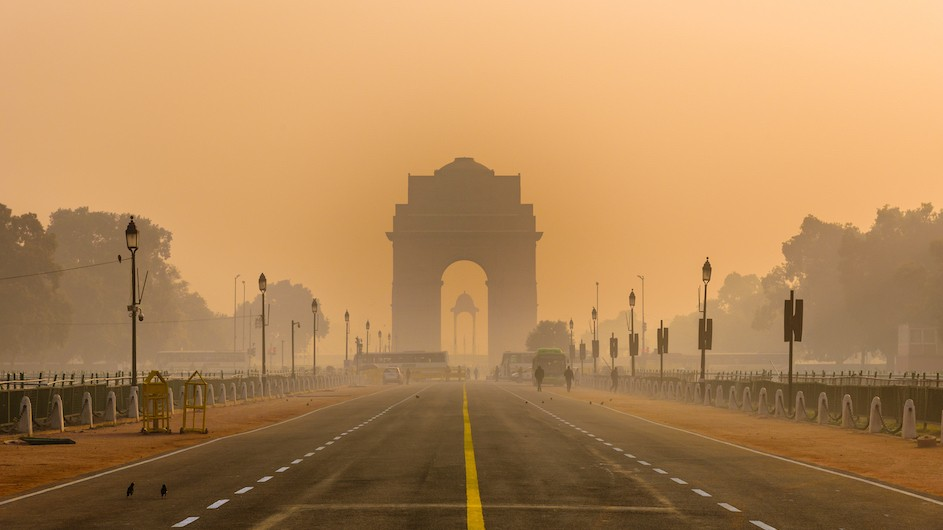

# Background

Air pollution has become one of the largest environmental health threats around the globe. India is among one of the most polluted countries in the world. According to 2021 [World Air Quality Report](https://www.iqair.com/world-air-quality-report), 12 out of 15 most polluted regional cities are in India. 

In this project, we are going to use 3 [datesets](https://www.kaggle.com/rohanrao/air-quality-data-in-india) from kaggle which contain air quality information from 2015 to 2020 in India. The data was originally published by the [Central Pollution Control Board](https://cpcb.nic.in/), an official portal of Indian Government.


## Import Packages

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.impute import KNNImputer
import matplotlib.pyplot as plt
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objs as go

from ipywidgets import widgets
from shapely.geometry import Point
import json
sns.set_style('whitegrid')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn import metrics, ensemble
from sklearn.metrics import confusion_matrix
from sklearn.neural_network import MLPRegressor
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf

## Download Datasets From Kaggle

We are going to download the datasets directly from Kaggle. After loading the `kaggle.json` file to Colab, run the following chunks:

In [ ]:
!pip install kaggle

In [ ]:
# create directory
!mkdir ~/.kaggle
# read json file
!cp kaggle.json ~/.kaggle/

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
# download the 3 datasets
!kaggle datasets download -d rohanrao/air-quality-data-in-india

air-quality-data-in-india.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
# unzip them
!unzip /content/air-quality-data-in-india.zip

Archive:  /content/air-quality-data-in-india.zip
replace city_day.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: city_day.csv            
replace city_hour.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: city_hour.csv           y

replace station_day.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename:   inflating: station_day.csv         
replace station_hour.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: station_hour.csv        
replace stations.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: stations.csv            


# Data Cleaning

3 datasets will be used in this project. We will first look into each of the datasets and conduct some preliminary data cleansing work.

*  `city_day.csv`: day-level air quality data for 26 **cities** from 2015 to 2020.

*  `station_day.csv`: day-level air quality data for 110 **stations** from 2015 to 2020. 

*  `stations.csv`: the city and state information for each station.

## Read in Raw Data and Conduct Data Cleansing for Three Datasets

In [ ]:
## Local Drive Version

# cityday_path = "drive/MyDrive/CIS545_Final_Project/data/city_day.csv"
# stationday_path = "drive/MyDrive/CIS545_Final_Project/data/station_day.csv"
# station_path = "drive/MyDrive/CIS545_Final_Project/data/stations.csv"

# city_day = pd.read_csv(cityday_path)
# station_day = pd.read_csv(stationday_path)
# stations = pd.read_csv(station_path)

In [ ]:
cityday_path = "city_day.csv"
stationday_path = "station_day.csv"
station_path = "stations.csv"

city_day = pd.read_csv(cityday_path)
station_day = pd.read_csv(stationday_path)
stations = pd.read_csv(station_path)

### city_day.csv

In [ ]:
city_day.head(3)

City        Date  PM2.5  PM10     NO    NO2    NOx  NH3     CO    SO2  \
0  Ahmedabad  2015-01-01    NaN   NaN   0.92  18.22  17.15  NaN   0.92  27.64   
1  Ahmedabad  2015-01-02    NaN   NaN   0.97  15.69  16.46  NaN   0.97  24.55   
2  Ahmedabad  2015-01-03    NaN   NaN  17.40  19.30  29.70  NaN  17.40  29.07   

       O3  Benzene  Toluene  Xylene  AQI AQI_Bucket  
0  133.36     0.00     0.02    0.00  NaN        NaN  
1   34.06     3.68     5.50    3.77  NaN        NaN  
2   30.70     6.80    16.40    2.25  NaN        NaN

This dataset records day-level air quality data for various cities in India.

The time range is from 2015.1.1 to 2020.7.1.

In [ ]:
# check time range
city_day["Date"] = pd.to_datetime(city_day["Date"])
print (city_day["Date"].min())
print (city_day["Date"].max())

2015-01-01 00:00:00
2020-07-01 00:00:00


26 cities are being recorded. 

In [ ]:
# check city
print ("number of unique city: {}".format(len(city_day["City"].unique())))
city_day["City"].unique()

number of unique city: 26


array(['Ahmedabad', 'Aizawl', 'Amaravati', 'Amritsar', 'Bengaluru',
       'Bhopal', 'Brajrajnagar', 'Chandigarh', 'Chennai', 'Coimbatore',
       'Delhi', 'Ernakulam', 'Gurugram', 'Guwahati', 'Hyderabad',
       'Jaipur', 'Jorapokhar', 'Kochi', 'Kolkata', 'Lucknow', 'Mumbai',
       'Patna', 'Shillong', 'Talcher', 'Thiruvananthapuram',
       'Visakhapatnam'], dtype=object)

As shown in the summary table below, there are about 30,000 observations in total. Data being recorded includes: PM2.5, PM10, NO, NO2, AQI, etc. 

**Null values** exist in many columns. For instance, out of the total 29,531 observations, `NH3` only has 19,203 valid entries, `Xylene` only has 11422 valid entries.

In [ ]:
city_day.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29531 entries, 0 to 29530
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   City        29531 non-null  object        
 1   Date        29531 non-null  datetime64[ns]
 2   PM2.5       24933 non-null  float64       
 3   PM10        18391 non-null  float64       
 4   NO          25949 non-null  float64       
 5   NO2         25946 non-null  float64       
 6   NOx         25346 non-null  float64       
 7   NH3         19203 non-null  float64       
 8   CO          27472 non-null  float64       
 9   SO2         25677 non-null  float64       
 10  O3          25509 non-null  float64       
 11  Benzene     23908 non-null  float64       
 12  Toluene     21490 non-null  float64       
 13  Xylene      11422 non-null  float64       
 14  AQI         24850 non-null  float64       
 15  AQI_Bucket  24850 non-null  object        
dtypes: datetime64[ns](1), 

We check the proportion of missing values for each column:

In [ ]:
for col in city_day.columns:
  prop_missing = round((sum(pd.isna(city_day[col]))/len(city_day))*100,2)
  print ("{} has {}% missing values".format(col, prop_missing))

City has 0.0% missing values
Date has 0.0% missing values
PM2.5 has 15.57% missing values
PM10 has 37.72% missing values
NO has 12.13% missing values
NO2 has 12.14% missing values
NOx has 14.17% missing values
NH3 has 34.97% missing values
CO has 6.97% missing values
SO2 has 13.05% missing values
O3 has 13.62% missing values
Benzene has 19.04% missing values
Toluene has 27.23% missing values
Xylene has 61.32% missing values
AQI has 15.85% missing values
AQI_Bucket has 15.85% missing values


We choose to first drop the columns with more than 20% missing values. They are: `PM10`, `NH3`, `Toluene`, `Xylene`. 

In [ ]:
city_day = city_day.drop(columns=["PM10", "NH3", "Toluene", "Xylene"])

Considering that our data involves time series, we do not think it is a good idea to simply drop rows with empty values, since that will cause our data to be disconnected. For the remaining columns with missing numerical values, we use KNN imputer to impute.

In [ ]:
missing_col = [col for col in city_day.columns if sum(pd.isna(city_day[col])>0) and col!="AQI_Bucket"]
imputer = KNNImputer()
imputer.fit(city_day[missing_col])
city_day[missing_col] = imputer.transform(city_day[missing_col])
city_day.head()

City       Date    PM2.5     NO    NO2    NOx     CO    SO2      O3  \
0  Ahmedabad 2015-01-01   23.178   0.92  18.22  17.15   0.92  27.64  133.36   
1  Ahmedabad 2015-01-02   27.004   0.97  15.69  16.46   0.97  24.55   34.06   
2  Ahmedabad 2015-01-03  121.276  17.40  19.30  29.70  17.40  29.07   30.70   
3  Ahmedabad 2015-01-04   40.012   1.70  18.48  17.97   1.70  18.59   36.08   
4  Ahmedabad 2015-01-05  142.728  22.10  21.42  37.76  22.10  39.33   39.31   

   Benzene    AQI AQI_Bucket  
0     0.00  122.4        NaN  
1     3.68  115.2        NaN  
2     6.80  363.6        NaN  
3     4.43  132.8        NaN  
4     7.01  453.8        NaN

The one column remaining is AQI_Bucket, which puts AQI index into different severity levels. The AQI_Bucket information is missing for the newly imputed AQI indexes.

We will get the criterion of each category and fill the missing category information accordingly.

In [ ]:
# obtain the AQI index range of each AQI_Bucket category
levels = ["Good", "Satisfactory", "Moderate", "Poor", "Very Poor", "Severe"]
bucket_dict = dict()
for level in levels:
  max_AQI = max(city_day[city_day["AQI_Bucket"]==level]["AQI"])
  min_AQI = min(city_day[city_day["AQI_Bucket"]==level]["AQI"])

  bucket_dict[level] = [min_AQI, max_AQI]

for level in levels:
  print ("For level '{}': AQI index range is {}".format(level, bucket_dict[level]))

For level 'Good': AQI index range is [13.0, 50.0]
For level 'Satisfactory': AQI index range is [51.0, 100.0]
For level 'Moderate': AQI index range is [101.0, 200.0]
For level 'Poor': AQI index range is [201.0, 300.0]
For level 'Very Poor': AQI index range is [301.0, 400.0]
For level 'Severe': AQI index range is [401.0, 2049.0]


In [ ]:
# Fill in the missing values in the AQI_Bucket column

def bucket_group(x):
    if x <= 50:
      return "Good"
    elif x <= 100:
      return "Satisfactory"
    elif x <= 200:
      return "Moderate"
    elif x <= 300:
      return "Poor"
    elif x <= 400:
      return "Very Poor"
    else:
      return "Severe"    

city_day.loc[pd.isna(city_day["AQI_Bucket"]),"AQI_Bucket"] = city_day.loc[pd.isna(city_day["AQI_Bucket"]),"AQI_Bucket"].apply(lambda x: bucket_group(x))

Upon this point, we have processed all missing values. 

In [ ]:
city_day.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29531 entries, 0 to 29530
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   City        29531 non-null  object        
 1   Date        29531 non-null  datetime64[ns]
 2   PM2.5       29531 non-null  float64       
 3   NO          29531 non-null  float64       
 4   NO2         29531 non-null  float64       
 5   NOx         29531 non-null  float64       
 6   CO          29531 non-null  float64       
 7   SO2         29531 non-null  float64       
 8   O3          29531 non-null  float64       
 9   Benzene     29531 non-null  float64       
 10  AQI         29531 non-null  float64       
 11  AQI_Bucket  29531 non-null  object        
dtypes: datetime64[ns](1), float64(9), object(2)
memory usage: 2.7+ MB


### station_day.csv

This dataset concerns with day-level air quality data for different stations in India.

In [ ]:
station_day.head(3)

StationId        Date  PM2.5    PM10    NO    NO2    NOx    NH3    CO  \
0     AP001  2017-11-24  71.36  115.75  1.75  20.65  12.40  12.19  0.10   
1     AP001  2017-11-25  81.40  124.50  1.44  20.50  12.08  10.72  0.12   
2     AP001  2017-11-26  78.32  129.06  1.26  26.00  14.85  10.28  0.14   

     SO2      O3  Benzene  Toluene  Xylene    AQI AQI_Bucket  
0  10.76  109.26     0.17     5.92    0.10    NaN        NaN  
1  15.24  127.09     0.20     6.50    0.06  184.0   Moderate  
2  26.96  117.44     0.22     7.95    0.08  197.0   Moderate

In [ ]:
station_day.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108035 entries, 0 to 108034
Data columns (total 16 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   StationId   108035 non-null  object 
 1   Date        108035 non-null  object 
 2   PM2.5       86410 non-null   float64
 3   PM10        65329 non-null   float64
 4   NO          90929 non-null   float64
 5   NO2         91488 non-null   float64
 6   NOx         92535 non-null   float64
 7   NH3         59930 non-null   float64
 8   CO          95037 non-null   float64
 9   SO2         82831 non-null   float64
 10  O3          82467 non-null   float64
 11  Benzene     76580 non-null   float64
 12  Toluene     69333 non-null   float64
 13  Xylene      22898 non-null   float64
 14  AQI         87025 non-null   float64
 15  AQI_Bucket  87025 non-null   object 
dtypes: float64(13), object(3)
memory usage: 13.2+ MB


Same as the city_day data, the time range of this dataset is also from 2015.1.1 to 2020.7.1.

In [ ]:
# check time range
station_day["Date"] = pd.to_datetime(station_day["Date"])
print (station_day["Date"].min())
print (station_day["Date"].max())

2015-01-01 00:00:00
2020-07-01 00:00:00


110 stations are included.

In [ ]:
print ("number of unique station: {}".format(len(station_day["StationId"].unique())))

number of unique station: 110


We conduct a similar data cleaning process as for `city_day.csv`. First drop `PM10`, `Toluene`, `Xylene`, `NH3`.

In [ ]:
station_day = station_day.drop(columns=["PM10", "NH3", "Toluene", "Xylene"])

Next, impute the numerical values using KNN Imputer.

In [ ]:
missing_col = [col for col in station_day.columns if sum(pd.isna(station_day[col])>0) and col!="AQI_Bucket"]
imputer = KNNImputer()
imputer.fit(station_day[missing_col])
station_day[missing_col] = imputer.transform(station_day[missing_col])
station_day.head()

StationId       Date  PM2.5    NO    NO2    NOx    CO    SO2      O3  \
0     AP001 2017-11-24  71.36  1.75  20.65  12.40  0.10  10.76  109.26   
1     AP001 2017-11-25  81.40  1.44  20.50  12.08  0.12  15.24  127.09   
2     AP001 2017-11-26  78.32  1.26  26.00  14.85  0.14  26.96  117.44   
3     AP001 2017-11-27  88.76  6.60  30.85  21.77  0.11  33.59  111.81   
4     AP001 2017-11-28  64.18  2.56  28.07  17.01  0.09  19.00  138.18   

   Benzene    AQI AQI_Bucket  
0     0.17   75.4        NaN  
1     0.20  184.0   Moderate  
2     0.22  197.0   Moderate  
3     0.29  198.0   Moderate  
4     0.17  188.0   Moderate

Finally, fill in the missing AQI_Bucket information.

In [ ]:
station_day.loc[pd.isna(station_day["AQI_Bucket"]),"AQI_Bucket"] = station_day.loc[pd.isna(station_day["AQI_Bucket"]),"AQI_Bucket"].apply(lambda x: bucket_group(x))

In [ ]:
station_day.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108035 entries, 0 to 108034
Data columns (total 12 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   StationId   108035 non-null  object        
 1   Date        108035 non-null  datetime64[ns]
 2   PM2.5       108035 non-null  float64       
 3   NO          108035 non-null  float64       
 4   NO2         108035 non-null  float64       
 5   NOx         108035 non-null  float64       
 6   CO          108035 non-null  float64       
 7   SO2         108035 non-null  float64       
 8   O3          108035 non-null  float64       
 9   Benzene     108035 non-null  float64       
 10  AQI         108035 non-null  float64       
 11  AQI_Bucket  108035 non-null  object        
dtypes: datetime64[ns](1), float64(9), object(2)
memory usage: 9.9+ MB


### stations.csv

This dataset has detailed station information. In particular, we can use this dataset to connect station with the city where the station belongs to. The `Status` column is not a useful column in this analysis. 

In [ ]:
stations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 230 entries, 0 to 229
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   StationId    230 non-null    object
 1   StationName  230 non-null    object
 2   City         230 non-null    object
 3   State        230 non-null    object
 4   Status       133 non-null    object
dtypes: object(5)
memory usage: 9.1+ KB


In [ ]:
stations = stations.drop(columns = ["Status"])

## Output Cleaned Dataset

In [ ]:
## Local Drive Version

# cityday_cleaned_path = "drive/MyDrive/CIS545_Final_Project/data/city_day_cleaned.csv"
# stationday_cleaned_path = "drive/MyDrive/CIS545_Final_Project/data/station_day_cleaned.csv"
# station_cleaned_path = "drive/MyDrive/CIS545_Final_Project/data/stations_cleaned.csv"

# city_day.to_csv(cityday_cleaned_path)
# station_day.to_csv(stationday_cleaned_path)
# stations.to_csv(station_cleaned_path)

In [ ]:
cityday_cleaned_path = "city_day_cleaned.csv"
stationday_cleaned_path = "station_day_cleaned.csv"
station_cleaned_path = "stations_cleaned.csv"

city_day.to_csv(cityday_cleaned_path)
station_day.to_csv(stationday_cleaned_path)
stations.to_csv(station_cleaned_path)

# Exploratory Data Analysis: What's Behind Air Pollution in India  (2015 - 2020)

## Read in Cleaned Data

In [ ]:
## Local Drive Version

# cityday_cleaned_path = "drive/MyDrive/CIS545_Final_Project/data/city_day_cleaned.csv"
# stationday_cleaned_path = "drive/MyDrive/CIS545_Final_Project/data/station_day_cleaned.csv"
# station_cleaned_path = "drive/MyDrive/CIS545_Final_Project/data/stations_cleaned.csv"

# city_day = pd.read_csv(cityday_cleaned_path,index_col=0)
# station_day = pd.read_csv(stationday_cleaned_path,index_col=0)
# stations = pd.read_csv(station_cleaned_path,index_col=0)

In [ ]:
cityday_cleaned_path = "city_day_cleaned.csv"
stationday_cleaned_path = "station_day_cleaned.csv"
station_cleaned_path = "stations_cleaned.csv"

city_day = pd.read_csv(cityday_cleaned_path,index_col=0)
station_day = pd.read_csv(stationday_cleaned_path,index_col=0)
stations = pd.read_csv(station_cleaned_path,index_col=0)

In [ ]:
city_day["Date"] = pd.to_datetime(city_day["Date"])
station_day["Date"] = pd.to_datetime(station_day["Date"])

In [ ]:
station_day['State'] = station_day.apply(lambda x:stations['State'].iloc[(np.where(stations['StationId'] == x['StationId']))[0][0]],axis=1)
city_day['State'] = city_day.apply(lambda x:stations['State'].iloc[(np.where(stations['City'] == x['City']))[0][0]],axis=1)

## Time Series Visualization

To start with, we will make a generic time series plot to get a sense of how AQI index in India involves from 2015 to 2020.

We aggregate the station-level data by date, obtaining the average AQI index of Index on each day.

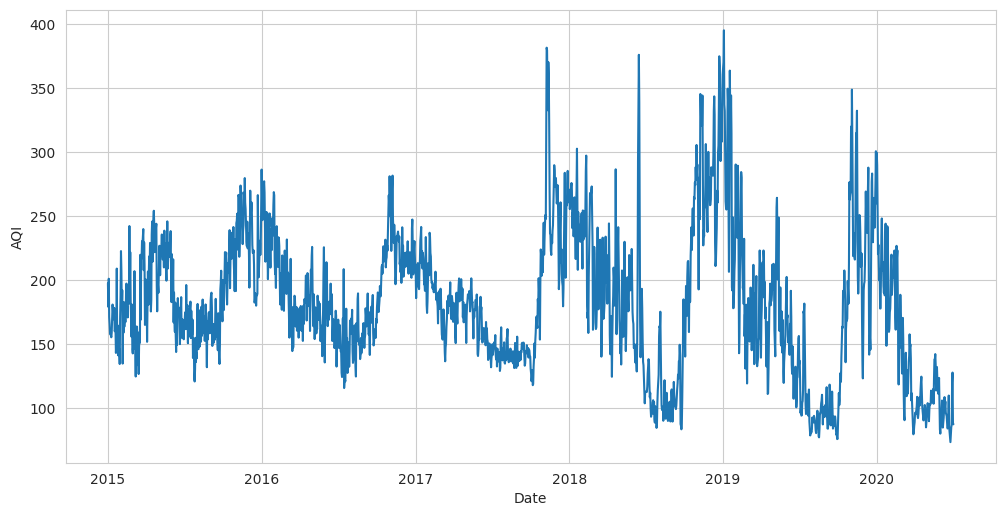

In [ ]:
plt.figure(figsize = (12,6),dpi = 100)

AQI_by_day = station_day[["Date","AQI"]].groupby(["Date"]).mean().reset_index()
sns.lineplot(data = AQI_by_day, x = "Date", y = "AQI")
plt.show()

We do not notice a clear trend in the AQI index from 2015 to 2020. There is a clear seasonality structure of the AQI index. In addition, the volatility changes over time.

## Data Visualization in Plotly: Regional Distribution

In order to use `Plotly` to visualize the regional distribution of our data, we need to do some pre-processing work first. In this section, we will install the required packages and india-polygon elements, then merge our dataset with the geometric characteristics.

In [ ]:
pip install geopandas

     |████████████████████████████████| 1.0 MB 5.5 MB/s 
     |████████████████████████████████| 6.3 MB 39.2 MB/s 
     |████████████████████████████████| 16.7 MB 13.2 MB/s 


In [ ]:
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objs as go
from ipywidgets import widgets
import geopandas as gpd
from shapely.geometry import Point
import json
sns.set_style('whitegrid')

### Data Processing (No need to run again)

State names and their corresponding geometric information:

In [ ]:
path = r'drive/MyDrive/CIS545_Final_Project/Map/india-polygon.shp'
map_df = gpd.read_file(path) 
map_df_copy = gpd.read_file(path)
map_df = map_df.rename(columns={'st_nm': 'State'})
map_df.head()
# map_df.City.value_counts()

id                        State  \
0  None  Andaman and Nicobar Islands   
1  None            Arunachal Pradesh   
2  None                        Assam   
3  None                        Bihar   
4  None                   Chandigarh   

                                            geometry  
0  MULTIPOLYGON (((93.84831 7.24028, 93.92705 7.0...  
1  POLYGON ((95.23643 26.68105, 95.19594 27.03612...  
2  POLYGON ((95.19594 27.03612, 95.08795 26.94578...  
3  POLYGON ((88.11357 26.54028, 88.28006 26.37640...  
4  POLYGON ((76.84208 30.76124, 76.83758 30.72552...

Merging with our dataset:

In [ ]:
city_day['year'] = pd.DatetimeIndex(city_day['Date']).year

In [ ]:
city_day['geometry'] = city_day.apply(lambda x:map_df['geometry'].iloc[(np.where(map_df['State'] == x['State']))[0][0]],axis=1)

/usr/local/lib/python3.7/dist-packages/pandas/core/dtypes/inference.py:383: ShapelyDeprecationWarning:

Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.

/usr/local/lib/python3.7/dist-packages/pandas/core/dtypes/inference.py:384: ShapelyDeprecationWarning:

__len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.

/usr/local/lib/python3.7/dist-packages/pandas/core/dtypes/cast.py:1990: ShapelyDeprecationWarning:

__len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.



In [ ]:
city_day.head()

/usr/local/lib/python3.7/dist-packages/pandas/core/dtypes/inference.py:383: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  iter(obj)  # Can iterate over it.
/usr/local/lib/python3.7/dist-packages/pandas/core/dtypes/inference.py:384: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  len(obj)  # Has a length associated with it.
/usr/local/lib/python3.7/dist-packages/pandas/io/formats/printing.py:118: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  s = iter(seq)
/usr/local/lib/python3.7/dist-packages/pandas/io/formats/printing.p

City       Date    PM2.5     NO    NO2    NOx     CO    SO2      O3  \
0  Ahmedabad 2015-01-01   23.178   0.92  18.22  17.15   0.92  27.64  133.36   
1  Ahmedabad 2015-01-02   27.004   0.97  15.69  16.46   0.97  24.55   34.06   
2  Ahmedabad 2015-01-03  121.276  17.40  19.30  29.70  17.40  29.07   30.70   
3  Ahmedabad 2015-01-04   40.012   1.70  18.48  17.97   1.70  18.59   36.08   
4  Ahmedabad 2015-01-05  142.728  22.10  21.42  37.76  22.10  39.33   39.31   

   Benzene    AQI AQI_Bucket    State  year  \
0     0.00  122.4     Severe  Gujarat  2015   
1     3.68  115.2     Severe  Gujarat  2015   
2     6.80  363.6     Severe  Gujarat  2015   
3     4.43  132.8     Severe  Gujarat  2015   
4     7.01  453.8     Severe  Gujarat  2015   

                                            geometry  
0  (POLYGON ((68.3580841977354 23.804748203159285...  
1  (POLYGON ((68.3580841977354 23.804748203159285...  
2  (POLYGON ((68.3580841977354 23.804748203159285...  
3  (POLYGON ((68.3580841977354 23.804748203159285...  
4  (POLYGON ((68.3580841977354 23.804748203159285...

In [ ]:
india_state_df = pd.read_csv('drive/MyDrive/CIS545_Final_Project/Map/state wise lat and long.csv')     # Reading the coordinates of Indian states for plotting purpose
india_state_df.head()

State  Longitude   Latitude
0  Andaman and Nicobar  92.904257  11.845455
1       Andhra Pradesh  79.973851  16.557796
2    Arunachal Pradesh  94.662314  27.729050
3                Assam  92.685686  26.336086
4                Bihar  85.625341  25.766303

In [ ]:
station_day = india_state_df.merge(station_day.set_index('State'),on='State')
city_day = india_state_df.merge(city_day.set_index('State'),on='State')
city_day.head()

State  Longitude   Latitude       City       Date  PM2.5    NO  \
0  Andhra Pradesh  79.973851  16.557796  Amaravati 2017-11-24  71.36  1.75   
1  Andhra Pradesh  79.973851  16.557796  Amaravati 2017-11-25  81.40  1.44   
2  Andhra Pradesh  79.973851  16.557796  Amaravati 2017-11-26  78.32  1.26   
3  Andhra Pradesh  79.973851  16.557796  Amaravati 2017-11-27  88.76  6.60   
4  Andhra Pradesh  79.973851  16.557796  Amaravati 2017-11-28  64.18  2.56   

     NO2    NOx    CO    SO2      O3  Benzene    AQI AQI_Bucket  year  \
0  20.65  12.40  0.10  10.76  109.26     0.17  117.4     Severe  2017   
1  20.50  12.08  0.12  15.24  127.09     0.20  184.0   Moderate  2017   
2  26.00  14.85  0.14  26.96  117.44     0.22  197.0   Moderate  2017   
3  30.85  21.77  0.11  33.59  111.81     0.29  198.0   Moderate  2017   
4  28.07  17.01  0.09  19.00  138.18     0.17  188.0   Moderate  2017   

                                            geometry  
0  POLYGON ((81.10544615182596 17.823133823951366...  
1  POLYGON ((81.10544615182596 17.823133823951366...  
2  POLYGON ((81.10544615182596 17.823133823951366...  
3  POLYGON ((81.10544615182596 17.823133823951366...  
4  POLYGON ((81.10544615182596 17.823133823951366...

In [ ]:
station_day.head()

State  Longitude_x  Latitude_x  Longitude_y  Latitude_y StationId  \
0  Andhra Pradesh    79.973851   16.557796    79.973851   16.557796     AP001   
1  Andhra Pradesh    79.973851   16.557796    79.973851   16.557796     AP001   
2  Andhra Pradesh    79.973851   16.557796    79.973851   16.557796     AP001   
3  Andhra Pradesh    79.973851   16.557796    79.973851   16.557796     AP001   
4  Andhra Pradesh    79.973851   16.557796    79.973851   16.557796     AP001   

        Date  PM2.5    NO    NO2    NOx    CO    SO2      O3  Benzene    AQI  \
0 2017-11-24  71.36  1.75  20.65  12.40  0.10  10.76  109.26     0.17   75.4   
1 2017-11-25  81.40  1.44  20.50  12.08  0.12  15.24  127.09     0.20  184.0   
2 2017-11-26  78.32  1.26  26.00  14.85  0.14  26.96  117.44     0.22  197.0   
3 2017-11-27  88.76  6.60  30.85  21.77  0.11  33.59  111.81     0.29  198.0   
4 2017-11-28  64.18  2.56  28.07  17.01  0.09  19.00  138.18     0.17  188.0   

  AQI_Bucket  
0     Severe  
1   Moderate  
2   Moderate  
3   Moderate  
4   Moderate

### Read in GPX Data

In [ ]:
# station_day.to_csv('station_day_gpx.csv')
# city_day.to_csv('city_day_gpx.csv')
cityday_gpx_path = "drbuive/MyDrive/CIS545_Final_Project/data/city_day_gpx.csv"
stationday_gpx_path = "drive/MyDrive/CIS545_Final_Project/data/station_day_gpx.csv"
city_day = pd.read_csv(cityday_gpx_path,index_col=0)
station_day = pd.read_csv(stationday_gpx_path,index_col=0)

In [ ]:
city_day['month'] = pd.DatetimeIndex(city_day['Date']).month
# city_day_mavg = pd.DataFrame(city_day.groupby(['State','City','year','month'])['AQI'].mean())
# city_day_yavg = pd.DataFrame(city_day.groupby(['City','year'])['AQI'].mean())
aggs = city_day.groupby(['State','City','year'])['AQI'].mean()
city_day_copy = city_day
city_day.drop(['AQI'], axis=1, inplace=True)
group_cols = ['State','City','year']
city_day.drop_duplicates(subset=group_cols, keep='last', inplace=True)
df = city_day.merge(right=aggs, right_index=True, left_on=['State','City','year'], how='right')

In [ ]:
df.head()

State  Longitude   Latitude           City        Date  PM2.5  \
37    Andhra Pradesh  79.973851  16.557796      Amaravati  2017-12-31  61.03   
402   Andhra Pradesh  79.973851  16.557796      Amaravati  2018-12-31  79.29   
767   Andhra Pradesh  79.973851  16.557796      Amaravati  2019-12-31  49.50   
950   Andhra Pradesh  79.973851  16.557796      Amaravati  2020-07-01  22.00   
1134  Andhra Pradesh  79.973851  16.557796  Visakhapatnam  2016-12-31  71.19   

         NO    NO2    NOx    CO    SO2     O3  Benzene    AQI_Bucket  year  \
37     5.51  39.50  25.49  0.08  11.45  61.91     0.33      Moderate  2017   
402    4.24  74.24  42.93  1.10  40.52  28.79     0.09      Moderate  2018   
767    1.67  12.64   8.05  0.64  17.14  64.80     0.70  Satisfactory  2019   
950    1.50   9.68   6.40  0.59  10.88  29.15     0.10  Satisfactory  2020   
1134  19.61  55.17  42.59  1.57   6.80  56.32     8.04      Moderate  2016   

                                               geometry  month         AQI  
37    POLYGON ((81.10544615182596 17.823133823951366...     12  190.536842  
402   POLYGON ((81.10544615182596 17.823133823951366...     12  102.968891  
767   POLYGON ((81.10544615182596 17.823133823951366...     12  107.203256  
950   POLYGON ((81.10544615182596 17.823133823951366...      7   59.879781  
1134  POLYGON ((81.10544615182596 17.823133823951366...     12  106.457508

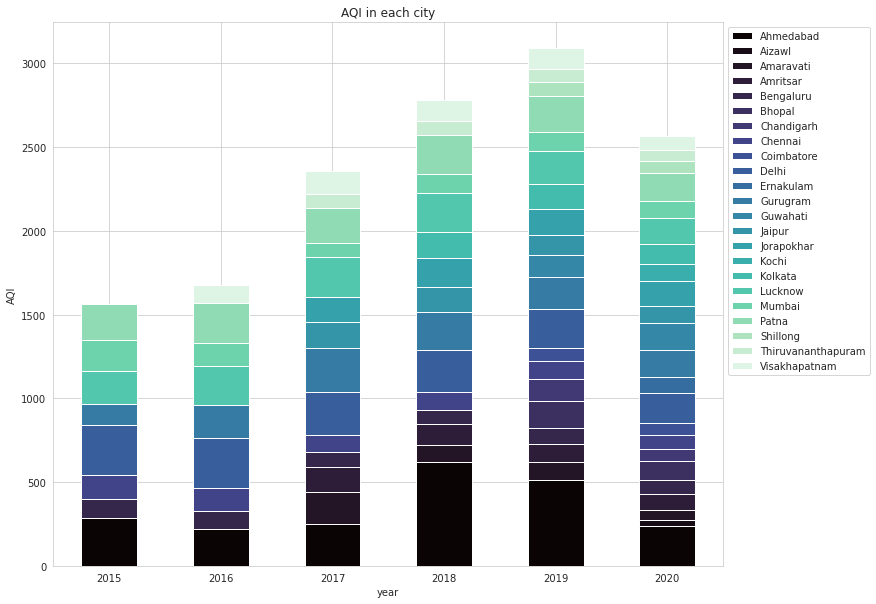

In [ ]:
city_day_wide = df.pivot(index="year", columns="City", values="AQI")
city_day_wide.plot.bar(
    rot=0,
    figsize=(12, 10),
    ylabel="AQI",
    title="AQI in each city",
    stacked=True,
    colormap= 'mako'
)
plt.legend(bbox_to_anchor=(1, 1),loc='upper left')

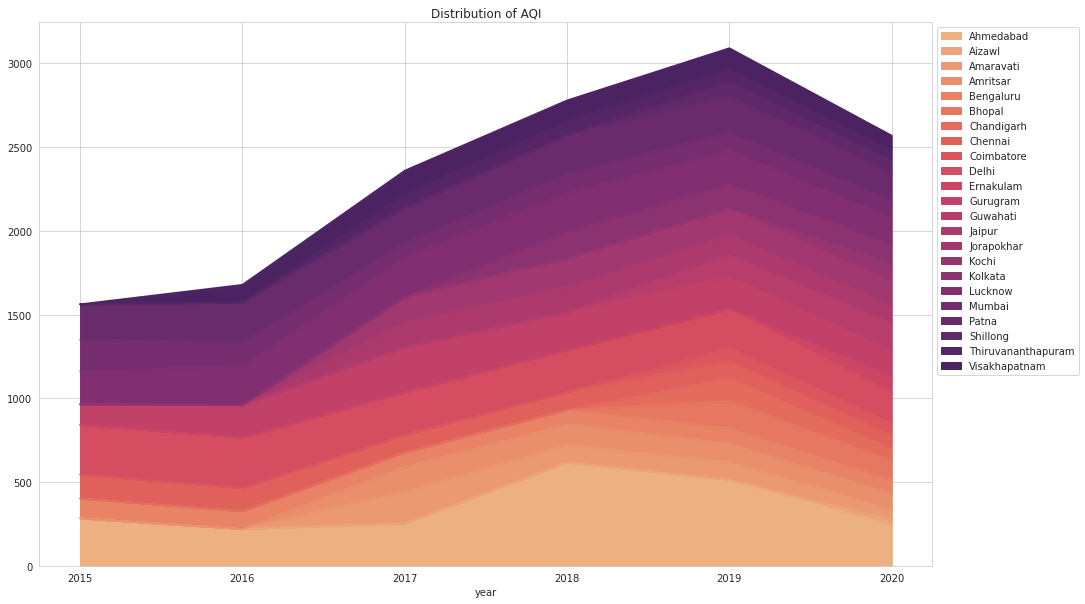

In [ ]:
city_day_wide.plot.area(
    rot=0,
    figsize=(16, 10),
    title="Distribution of AQI",
    stacked=True,
    colormap = 'flare'
)
plt.legend(bbox_to_anchor=(1, 1),loc='upper left')

### Choropleth Map

A choropleth map uses color intensity to show the aggregate summary of certain variables on a geographical map. 

Here, we will show the AQI index involvement of several different states included in our dataset. We use `station_day.csv` and calculate the average AQI index of all stations in a given state each year. 

In [ ]:
!pip install chart-studio

     |████████████████████████████████| 64 kB 2.0 MB/s 
  Created wheel for retrying: filename=retrying-1.3.3-py3-none-any.whl size=11447 sha256=faadac71ac3c1912e1c88f69f07516c3c5dc8bc1ef9a0594a0d54a2653c82c50
  Stored in directory: /root/.cache/pip/wheels/f9/8d/8d/f6af3f7f9eea3553bc2fe6d53e4b287dad18b06a861ac56ddf
Successfully built retrying


In [ ]:
import chart_studio
username='ChiaPatricia'
api_key='rkYaQev7E26gjSK5SrxA'
chart_studio.tools.set_credentials_file(username=username,api_key=api_key)

In [ ]:
import geopandas as gpd
import pyproj

Import Indian Geometric Shape file:

In [ ]:
# Indian Shapefile
indian_shp = gpd.read_file('drive/MyDrive/CIS545_Final_Project/Map/india-polygon.shp')
indian_shp.to_crs(pyproj.CRS.from_epsg(4326), inplace=True)
indian_shp = indian_shp.drop(columns = 'id').rename(columns = {'st_nm':'State'})
indian_shp.head()

State  \
0  Andaman and Nicobar Islands   
1            Arunachal Pradesh   
2                        Assam   
3                        Bihar   
4                   Chandigarh   

                                            geometry  
0  MULTIPOLYGON (((93.84831 7.24028, 93.92705 7.0...  
1  POLYGON ((95.23643 26.68105, 95.19594 27.03612...  
2  POLYGON ((95.19594 27.03612, 95.08795 26.94578...  
3  POLYGON ((88.11357 26.54028, 88.28006 26.37640...  
4  POLYGON ((76.84208 30.76124, 76.83758 30.72552...

Process to get the aggregate AQI index data:

In [ ]:
station_day.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 97420 entries, 0 to 97419
Data columns (total 19 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   State       97420 non-null  object 
 1   Longitude   97420 non-null  float64
 2   Latitude    97420 non-null  float64
 3   StationId   97420 non-null  object 
 4   Date        97420 non-null  object 
 5   PM2.5       97420 non-null  float64
 6   PM10        97420 non-null  float64
 7   NO          97420 non-null  float64
 8   NO2         97420 non-null  float64
 9   NOx         97420 non-null  float64
 10  NH3         97420 non-null  float64
 11  CO          97420 non-null  float64
 12  SO2         97420 non-null  float64
 13  O3          97420 non-null  float64
 14  Benzene     97420 non-null  float64
 15  Toluene     97420 non-null  float64
 16  Xylene      97420 non-null  float64
 17  AQI         97420 non-null  float64
 18  AQI_Bucket  97420 non-null  object 
dtypes: float64(15), object(4)

In [ ]:
station_average = station_day.copy()
station_average['Date'] = pd.to_datetime(station_average['Date'])
station_average['Year'] = station_average['Date'].apply(lambda x:x.year)
station_average = station_average.groupby(by = ['StationId','Year']).mean().reset_index()

In [ ]:
state_df = indian_shp[['State']]
state_df[2015] = 0
state_df[2016] = 0
state_df[2017] = 0
state_df[2018] = 0
state_df[2019] = 0
state_df[2020] = 0
state_df = state_df.melt(id_vars='State', value_vars=[2015,2016,2017,2018,2019,2020])
state_df = state_df.drop(columns='value').rename(columns = {'variable':'Year'})

In [ ]:
station_state = station_average.merge(stations, on = 'StationId', how = 'left').groupby(by = ['State','Year']).mean().reset_index()
station_state = state_df.merge(station_state, on = ['State', 'Year'], how = 'left').sort_values(by=['State','Year'])

In [ ]:
map_data = indian_shp.join(station_state.set_index('State'), on = 'State')
map_data = map_data.set_index('State')

Click on the "play" button to start the automatic animation！

In [ ]:
import plotly.express as px
import chart_studio.plotly as py
import chart_studio.tools as tls
fig = px.choropleth(map_data,
            geojson = map_data.geometry,
            locations = map_data.index,
            color= 'AQI',
            projection="mercator",
            color_continuous_scale="RdBu_r",
            scope = 'asia',
            # color_discrete_map = {'missing':'grey'},
            range_color = [0,320],
            hover_data = ['PM2.5','NO','NO2','NOx'],
            animation_frame = 'Year')
fig.update_geos(fitbounds="locations")
fig.show()

In [ ]:
# host this graph live on Plotly 
py.plot(fig, filename="plotly_map", auto_open = True)

'https://plotly.com/~ChiaPatricia/5/'

In [ ]:
import plotly.io as pio
pio.write_html(fig, file='index.html', auto_open=True)

### Sunburst Chart

A Sunburst chart visualizes a hierarchical data structure by a series of concentric rings.

We will visualize the average AQI index at the station level, city level, and state-level through a sunburst chart.

In [ ]:
sunburst_data = station_day.copy()
sunburst_data = sunburst_data.groupby(by = 'StationId').mean().reset_index().merge(stations, on='StationId')

The Outer ring corresponds to each station. The middle ring corresponds to the city to which the stations belong. The inner ring is the state to which the cities belong.



In [ ]:
fig = px.sunburst(sunburst_data, path=['State', 'City','StationId'], color='AQI', values = 'AQI',
                  hover_data=['StationName'],
                  color_continuous_scale='RdBu_r',
                  width=1000,height=900)
fig.update_layout(title = {'text': 'Sunburst', 'y' : 0.96, 'x' : 0.5},
                  title_font_size = 20)
fig.show()

In [ ]:
py.plot(fig, filename="plotly_sunburst", auto_open = True)

'https://plotly.com/~ChiaPatricia/3/'

We can see that Lucknow, Ahmedabad and Delhi are the top 3 polluted states. Gurugram and Patna have some polluted station records, but they are less polluted on a state level. In general, States Mizoram, Bengaluru and Hyderdabad have good air quality. 

## State-Level Analysis

Now, we will proceed to perform some more explorations at the state-level and city-level, respectively. respectivly.

We first merge `stations.csv` and `station_day.csv` to obtain the `State` and `City` information for each station.

In [ ]:
station_day = pd.read_csv(stationday_cleaned_path,index_col=0)
station_full = station_day.merge(stations[["StationId", "City", "State"]], on = "StationId", how = "left")
station_full.head(3)

StationId        Date  PM2.5    PM10    NO    NO2    NOx    NH3    CO  \
0     AP001  2017-11-24  71.36  115.75  1.75  20.65  12.40  12.19  0.10   
1     AP001  2017-11-25  81.40  124.50  1.44  20.50  12.08  10.72  0.12   
2     AP001  2017-11-26  78.32  129.06  1.26  26.00  14.85  10.28  0.14   

     SO2      O3  Benzene  Toluene  Xylene    AQI AQI_Bucket       City  \
0  10.76  109.26     0.17     5.92    0.10   96.4     Severe  Amaravati   
1  15.24  127.09     0.20     6.50    0.06  184.0   Moderate  Amaravati   
2  26.96  117.44     0.22     7.95    0.08  197.0   Moderate  Amaravati   

            State  
0  Andhra Pradesh  
1  Andhra Pradesh  
2  Andhra Pradesh

Now, we are going to find the average PM2.5 and AQI levels of each state over 5 years. The result is sorted by the average AQI level ---- we can see that on average, **Mizoram, Meghalaya, Kerala and Chandigarh** have AQI index lower than 100, while **Bihar, Uttar Pradesh, Delhi and Gujarat** have AQI index higher than 200.

In [ ]:
res = station_full[["State", "PM2.5", "AQI"]].groupby("State").mean().reset_index().\
rename(columns={"PM2.5": "Average PM2.5", "AQI": "Average AQI"}).sort_values("Average AQI")
res

State  Average PM2.5  Average AQI
13         Mizoram      17.733257    35.677876
12       Meghalaya      41.608622    77.198473
9           Kerala      29.305995    84.143104
3       Chandigarh      41.849349    96.432895
18       Telangana      64.942560   101.603519
8        Karnataka      52.391493   103.839766
0   Andhra Pradesh      57.365976   108.294152
15          Punjab      55.307560   120.278036
11     Maharashtra      53.646223   126.440447
20     West Bengal      58.333297   131.656246
10  Madhya Pradesh      51.000461   133.913300
16       Rajasthan      56.188845   134.869677
1            Assam      63.751876   139.676494
17      Tamil Nadu      48.910498   144.036135
14          Odisha      64.952416   159.474326
7        Jharkhand      64.321602   164.438274
6          Haryana     100.865139   199.320327
2            Bihar     103.133982   201.563751
19   Uttar Pradesh     104.655313   206.507259
4            Delhi     104.926517   225.741905
5          Gujarat      68.044118   360.863803

Below is a visualization of the result. We can see that State **Gujarat** is very outstanding with the **poorest** air quality in terms of AQI Index. On the other hand, state **Mizoram** has the **lowest** AQI Index on average. Its average PM2.5 is also the lowest among all states.

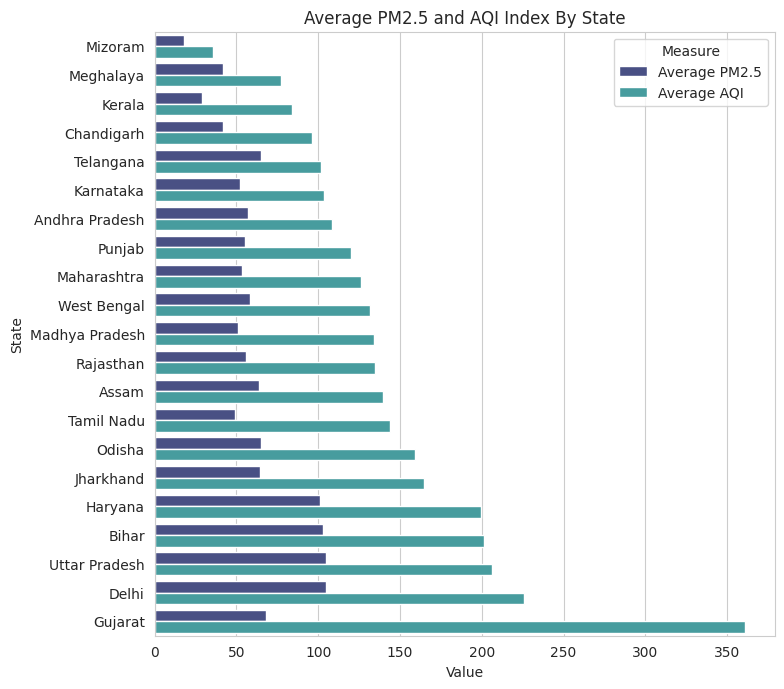

In [ ]:
melted = pd.melt(res, id_vars="State", var_name="Measure", value_name="Value")
plt.figure(figsize=(8,8), dpi = 100)
sns.barplot(data=melted, y = "State", x = "Value", hue = "Measure", palette='mako').set(title = "Average PM2.5 and AQI Index By State")
plt.show()

Out of all the records in Gujarat's stations, how is the distribution of AQI_Bucket? 

There is only 1 *Good* record in total. There are 1313 *Severe* records! Gujarat is indeed a very polluted state.

In [ ]:
Guj = station_full[station_full["State"] == "Gujarat"]
val_counts = pd.DataFrame(Guj["AQI_Bucket"].value_counts())
order = ['Good', 'Satisfactory','Moderate','Poor','Very Poor','Severe']
Guj_res = val_counts.loc[order].reset_index().rename(columns = {"AQI_Bucket": "Number of Records", "index":"AQI_Bucket"})
Guj_res

AQI_Bucket  Number of Records
0          Good                  1
1  Satisfactory                 43
2      Moderate                198
3          Poor                238
4     Very Poor                216
5        Severe               1313

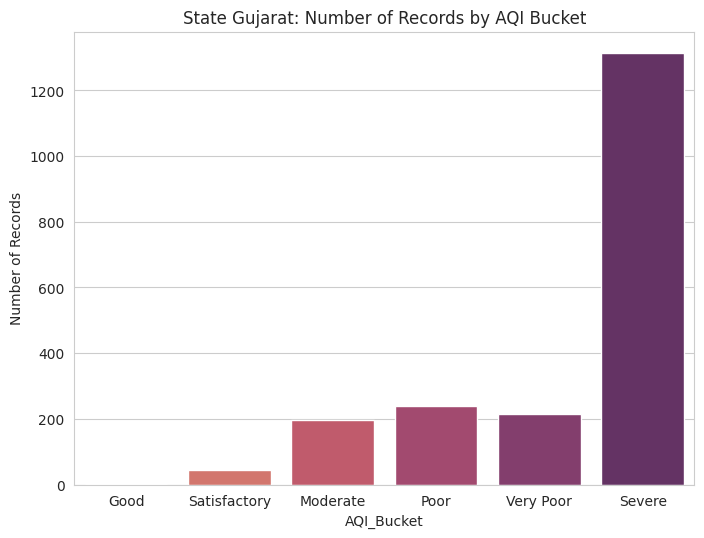

In [ ]:
plt.figure(figsize = (8,6),dpi = 100)
sns.barplot(data = Guj_res, x = "AQI_Bucket", y = "Number of Records",palette='flare').\
set(title = "State Gujarat: Number of Records by AQI Bucket")
plt.show()

How about State Delhi, which is the second polluted state? The total number of records in Delhi is more than the number of records for Gujarat. Out of 45360 records across different stations in Delhi over the past 5 years, there are 13014 records for which AQI Index is at *Severe* level.

In [ ]:
Del = station_full[station_full["State"] == "Delhi"]
print ("Total number of records in State Delhi: {}".format(len(Del)))
val_counts = pd.DataFrame(Del["AQI_Bucket"].value_counts())
order = ['Good', 'Satisfactory','Moderate','Poor','Very Poor','Severe']
Del_res = val_counts.loc[order].reset_index().rename(columns = {"AQI_Bucket": "Number of Records", "index":"AQI_Bucket"})
Del_res

Total number of records in State Delhi: 45360


AQI_Bucket  Number of Records
0          Good                301
1  Satisfactory               4713
2      Moderate              11690
3          Poor               7344
4     Very Poor               8298
5        Severe              13014

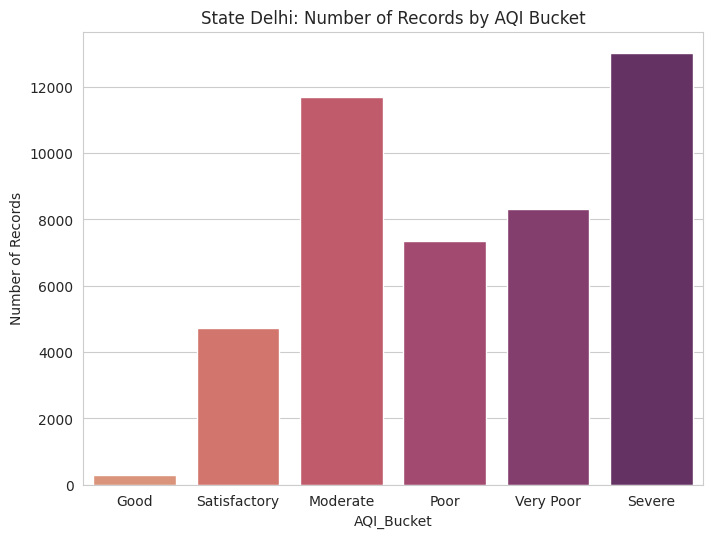

In [ ]:
plt.figure(figsize = (8,6),dpi = 100)
sns.barplot(data = Del_res, x = "AQI_Bucket", y = "Number of Records",palette='flare').\
set(title = "State Delhi: Number of Records by AQI Bucket")
plt.show()

## City-Level Analysis

We are going to do some data explorations for the `city_day` dataset, which records the AQI index of **26 cities at day-level**. 

We would like to see the highest AQI index that a city had across all records:



In [ ]:
city_day = pd.read_csv(cityday_cleaned_path,index_col=0)
city_day["Date"] = pd.to_datetime(city_day["Date"])
city_day[["City", "AQI"]].groupby("City").max().reset_index().\
rename(columns = {"AQI": "Highest AQI"}).sort_values("Highest AQI", ascending = False)

City  Highest AQI
0            Ahmedabad  2049.000000
13            Guwahati   956.000000
12            Gurugram   891.000000
3             Amritsar   869.000000
14           Hyderabad   737.000000
10               Delhi   716.000000
19             Lucknow   707.000000
20              Mumbai   637.800000
21               Patna   619.000000
16          Jorapokhar   604.000000
23             Talcher   570.000000
18             Kolkata   475.000000
15              Jaipur   457.000000
8              Chennai   449.000000
25       Visakhapatnam   387.000000
4            Bengaluru   369.400000
6         Brajrajnagar   355.000000
7           Chandigarh   335.000000
5               Bhopal   312.000000
2            Amaravati   312.000000
17               Kochi   277.000000
24  Thiruvananthapuram   230.000000
22            Shillong   182.000000
11           Ernakulam   180.000000
9           Coimbatore   166.463581
1               Aizawl    95.400000

**Ahmedabad, Guwahati, Gurugram** got some very high AQI indexes. On the other hand, **Aizawl** seems to have good air quality. 

**Fun fact**: *Aizawl is the capital of the state of Mizoram, which is the state with the finest air quality according to our analysis in the previous section.*

Now, we will take a closer look at **Ahmedabad**, the most polluted city in the dataset. Here, we calculate the average air quality of **Ahmedabad** over each week, and investigate how it evolves over the year, and across different years.

In [ ]:
Ahm = city_day[city_day["City"]=="Ahmedabad"]
Ahm["Year"] = Ahm["Date"].apply(lambda x: x.year)
Ahm["Month"] = Ahm["Date"].apply(lambda x: x.month)
Ahm["Week"] = Ahm["Date"].apply(lambda x: x.week)
Ahm_WOY = Ahm.groupby(["Year","Week"]).mean().reset_index()[["Year","Week","PM2.5","CO","AQI"]]
Ahm_WOY.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/st

Year  Week       PM2.5         CO         AQI
0  2015     1   52.867500   5.247500  183.500000
1  2015     2   80.859429  60.252857  516.428571
2  2015     3   75.608000  19.975714  351.542857
3  2015     4   73.940000   7.854286  210.628571
4  2015     5  106.316286  14.118571  336.657143

AQI Index Change in Years 2018, 2019 and 2020:

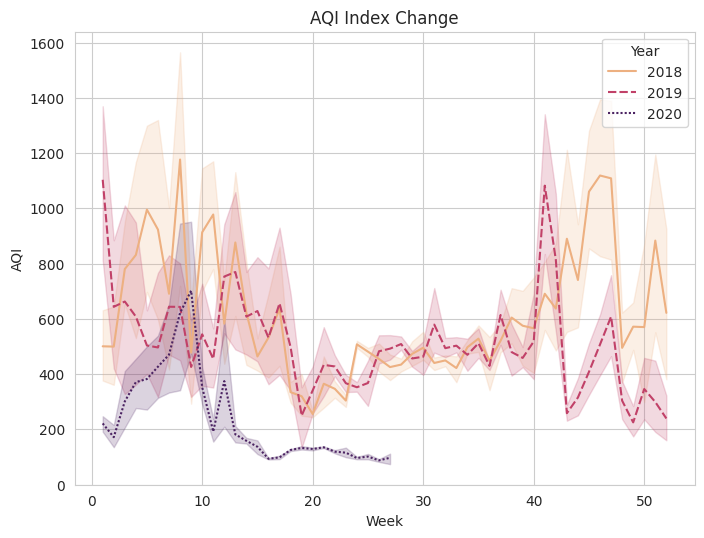

In [ ]:
plt.figure(figsize = (8,6),dpi = 100)
sns.lineplot(data = Ahm[Ahm["Year"].isin([2018, 2019, 2020])], x = "Week", y = "AQI", 
             hue = "Year",style = "Year", palette="flare").set(title = "AQI Index Change")
plt.show()

CO level change in Years 2018, 2019, 2020:

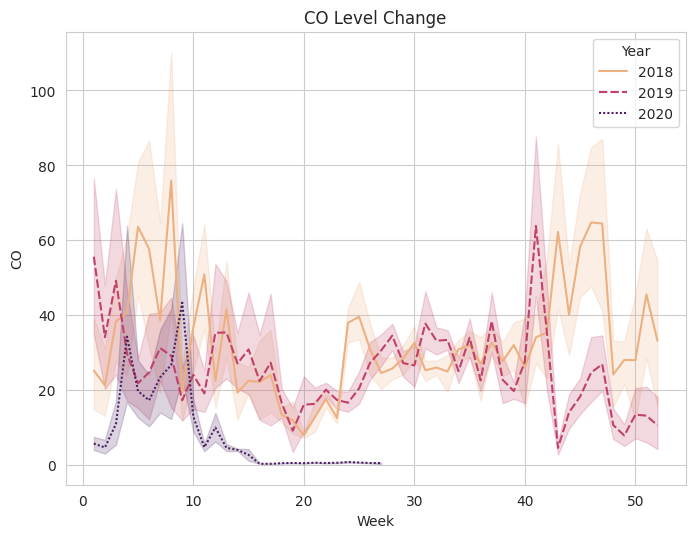

In [ ]:
plt.figure(figsize = (8,6),dpi = 100)
sns.lineplot(data = Ahm[Ahm["Year"].isin([2018, 2019, 2020])], x = "Week", y = "CO", 
             hue = "Year", style = "Year", palette = "flare").set(title = "CO Level Change")
plt.show()

PM 2.5 Change in Years 2018, 2019 and 2020:

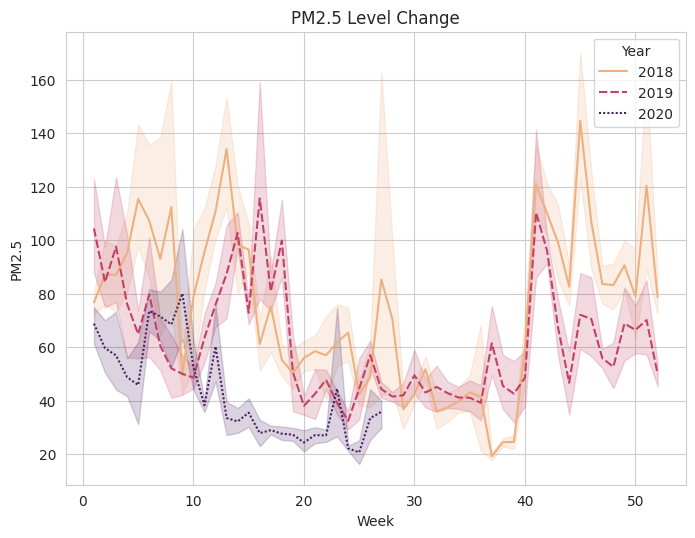

In [ ]:
plt.figure(figsize = (8,6),dpi = 100)
sns.lineplot(data = Ahm[Ahm["Year"].isin([2018, 2019, 2020])], x = "Week", y = "PM2.5", 
             hue = "Year", style = "Year", palette = "flare").set(title = "PM2.5 Level Change")
plt.show()

Notice that our dataset is incomplete for year 2020, since the last record date is 2020.7.1. From the above three plots, we can see that the fluctuations of AQI Index, CO and PM2.5 follow roughly the same pattern. In years 2018 and 2019, air quality is better in the middle of the year (summer months) than in the beginning and the end of year (winter months). The end of 2018 has poorer air quality than the end of 2019, while the air quality in 2020 is better compared to the corresponding months in 2018 and 2019. 

According to [IQAir Clean Air Facility program](https://www.iqair.com/us/india/gujarat/ahmedabad), the main sources of pollution in Ahm are vehicles and coal-fired power plants emissions. During 2020, COVID outbreak may significantly impact personal travel and cause factories to shut down. This can explain why the air quality in 2020 become better than in previous years.



## Correlations Between Variables

Before the modeling part, we will quickly explore the correlations between variables. 

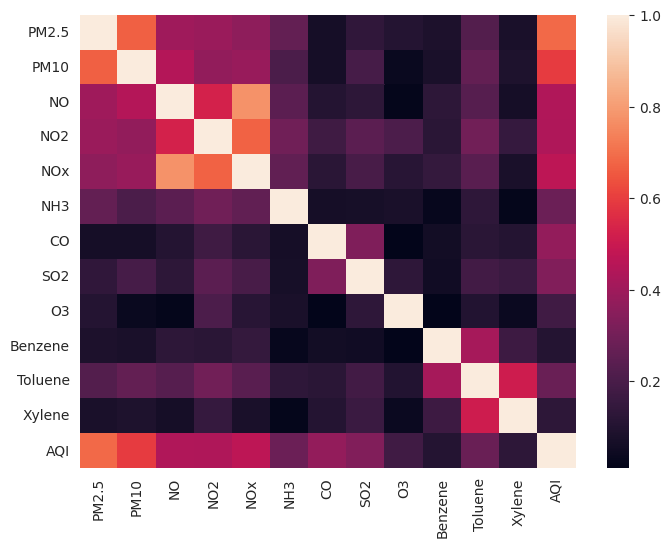

In [ ]:
plt.figure(figsize = (8,6),dpi = 100)
corr_matrix = station_day.corr()
sns.heatmap(corr_matrix)
plt.show()

From the above heatmap, we can see that AQI is mostly correlated with PM2.5. AQI is least correlated with Benzene. In addition, NO and NOx have relatively high correlations.

Visualizing the relationship between PM2.5 and AQI:

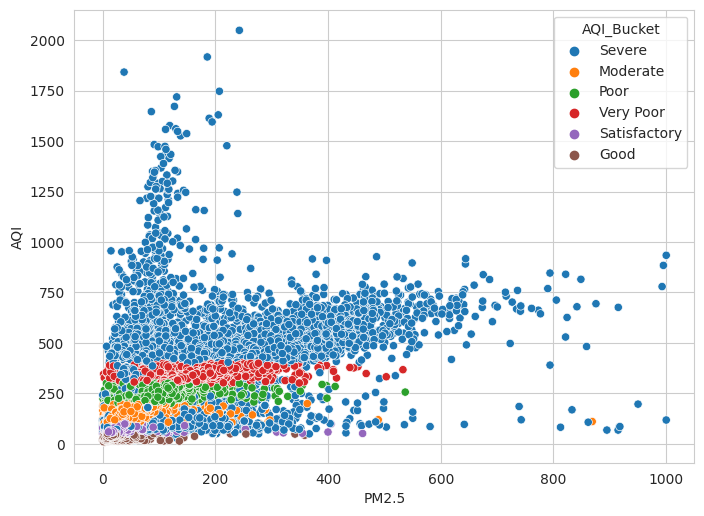

In [ ]:
plt.figure(figsize = (8,6),dpi = 100)
# order = ['Good', 'Satisfactory','Moderate','Poor','Very Poor','Severe']
# sns.scatterplot(data = station_day.set_index("AQI_Bucket").loc[order].reset_index(), x = "PM2.5", y = "AQI", hue = "AQI_Bucket", style = "AQI_Bucket")
sns.scatterplot(data = station_day, x = "PM2.5", y = "AQI", hue = "AQI_Bucket")
plt.show()

The pattern between PM2.5 and AQI is actually not very clear through the scatter plot. Higher PM2.5 may be associated higher AQI, but the association is not very strong.

Visualizing the relationship between Benzene and AQI:

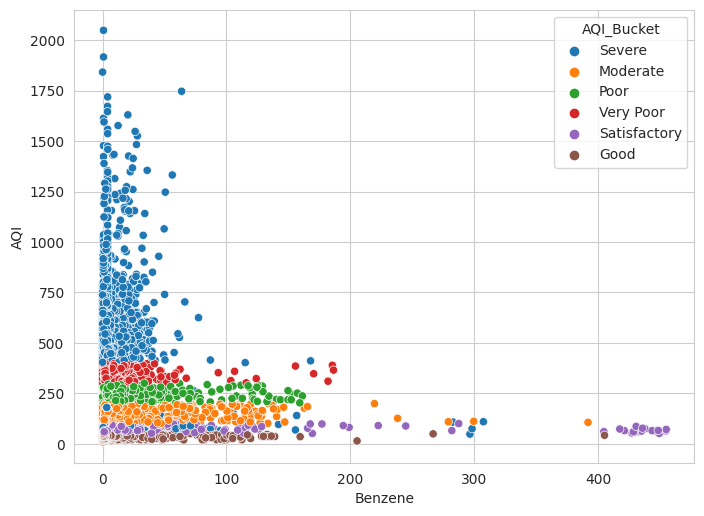

In [ ]:
plt.figure(figsize = (8,6),dpi = 100)
sns.scatterplot(data = station_day, x = "Benzene", y = "AQI", hue = "AQI_Bucket")
plt.show()

Indeed, Benzene and AQI seem to be poorly associated. 

Visualizing the relationship between NO and NOx:

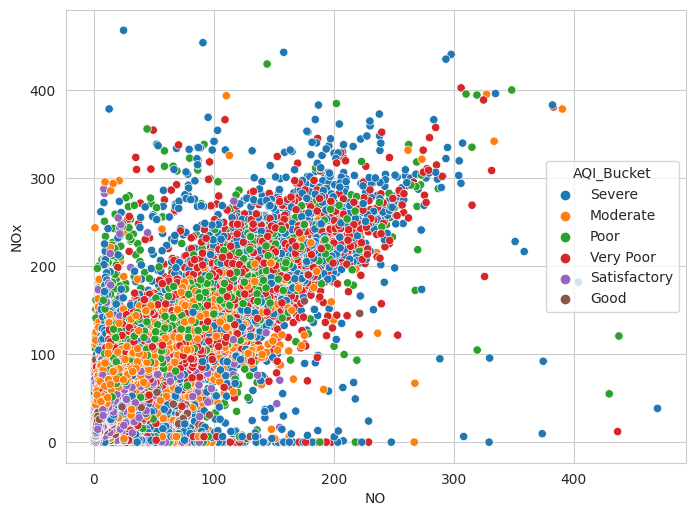

In [ ]:
plt.figure(figsize = (8,6),dpi = 100)
sns.scatterplot(data = station_day, x = "NO", y = "NOx", hue = "AQI_Bucket")

We see a strong correlation between NO and NOx in this scatter plot. However, there is not a clear pattern in regards of AQI_Bucket.

# Model Building: Predicting Air Quality Index in India


In this section, we implement various models for the AQI index at the station level.

Linear regression model, Gradient Boosting Regression, Neural Network are used.

## Preprocessing

### Feature Engineering

In [ ]:
# cityday_cleaned_path = "drive/MyDrive/CIS545_Final_Project/data/city_day_cleaned.csv"
# stationday_cleaned_path = "drive/MyDrive/CIS545_Final_Project/data/station_day_cleaned.csv"
# station_cleaned_path = "drive/MyDrive/CIS545_Final_Project/data/stations_cleaned.csv"
# city_day = pd.read_csv(cityday_cleaned_path,index_col=0)
# station_day = pd.read_csv(stationday_cleaned_path,index_col=0)
# stations = pd.read_csv(station_cleaned_path,index_col=0)

In [ ]:
cityday_cleaned_path = "city_day_cleaned.csv"
stationday_cleaned_path = "station_day_cleaned.csv"
station_cleaned_path = "stations_cleaned.csv"

city_day = pd.read_csv(cityday_cleaned_path,index_col=0)
station_day = pd.read_csv(stationday_cleaned_path,index_col=0)
stations = pd.read_csv(station_cleaned_path,index_col=0)

Before feeding the data into the models, we will first drop meaningless variables and create additional features.

In the EDA part, we have noticed that PM2.5 has a relatively high correlation with AQI index, and that PM2.5 varies greatly among cities. Thus, we decide to create an additional feature - the average PM2.5 of the city in which the station belongs to. 



The `cidy_day` dataframe records PM2.5 of each city on each day. We aggregate the data by `city` to get the average PM2.5 of each city.

In [ ]:
city_avg = city_day[["City","PM2.5"]].groupby("City").mean().reset_index().rename(columns = {"PM2.5": "city_avg_PM2.5"})
city_avg.head()

City  city_avg_PM2.5
0  Ahmedabad       64.211966
1     Aizawl       17.009558
2  Amaravati       39.412807
3   Amritsar       56.149741
4  Bengaluru       37.673413

Next, we **merge** the average PM2.5 of each city with `station_day` dataframe. We also **drop** 4 features that should not be used in the model, which are "StationId", "Date", "City", "AQI_Bucket".

In [ ]:
model_data = station_day.merge(stations[["StationId", "City"]], how = "left", on = "StationId").\
merge(city_avg, how = "left", on = "City").\
drop(columns = ["StationId", "Date", "City", "AQI_Bucket"])

model_data.head()

PM2.5    PM10    NO    NO2    NOx    NH3    CO    SO2      O3  Benzene  \
0  71.36  115.75  1.75  20.65  12.40  12.19  0.10  10.76  109.26     0.17   
1  81.40  124.50  1.44  20.50  12.08  10.72  0.12  15.24  127.09     0.20   
2  78.32  129.06  1.26  26.00  14.85  10.28  0.14  26.96  117.44     0.22   
3  88.76  135.32  6.60  30.85  21.77  12.91  0.11  33.59  111.81     0.29   
4  64.18  104.09  2.56  28.07  17.01  11.42  0.09  19.00  138.18     0.17   

   Toluene  Xylene    AQI  city_avg_PM2.5  
0     5.92    0.10   96.4       39.412807  
1     6.50    0.06  184.0       39.412807  
2     7.95    0.08  197.0       39.412807  
3     7.63    0.12  198.0       39.412807  
4     5.02    0.07  188.0       39.412807

In [ ]:
len(model_data)

108035

Thus, in the end, we will use 9 features (PM2.5, NO, NO2, NOx, CO, SO2, O3, Benzene, average PM2.5 of the city) to predict the AQI index. There are 108035 observations in total.

### Train and Test Split

80% of the dataset will be used for training. The remaining 20% will be used for testing.

In [ ]:
X = model_data.drop(columns=["AQI"])
y = model_data["AQI"]

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1)

scaler = StandardScaler()                                 
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

## Model 1: Linear Regression

Our first attemp is a linear regression model.

### Implementation

In [ ]:
lr_model = LinearRegression().fit(x_train_scaled, y_train)
y_pred_lr = lr_model.predict(x_test_scaled)

### Evaluation

In [ ]:
lr_R2 = lr_model.score(x_test_scaled, y_test)
lr_MAE = metrics.mean_absolute_error(y_test, y_pred_lr)
lr_MSS = metrics.mean_squared_error(y_test, y_pred_lr)  

print ("The R^2 score is {}".format(round(lr_R2,3)))
print ("The MAE  is {}".format(round(lr_MAE,3)))
print ("the MSS is {}".format(round(lr_MSS,3)))

The R^2 score is 0.682
The MAE  is 44.256
the MSS is 4789.88


1. The coefficient of determination (R squared) on the training set is 0.682. This means that 68.2% of the variation in the AQI index can be explained by our input features.
2. Mean absolute error = 44.256
3. Mean squared error = 4789.88

Below, we plot the true AQI index versus the predicted value for our testing dataset. We can see that the model does a decent job in prediction.

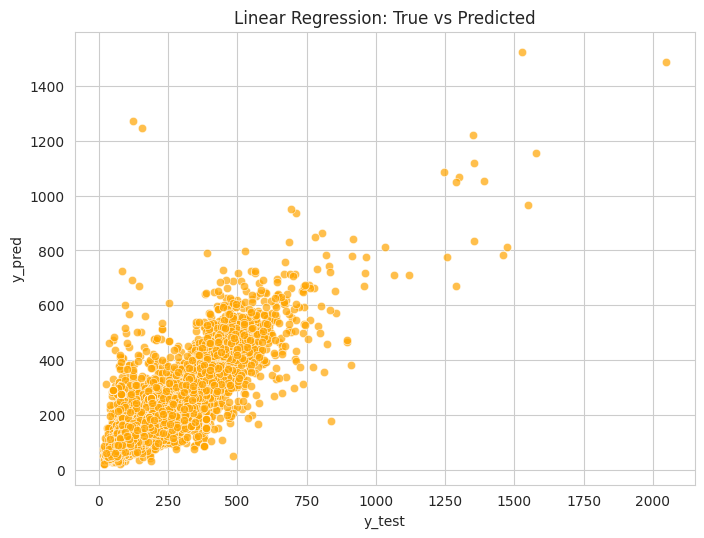

In [ ]:
lr_df = pd.DataFrame({"y_pred":y_pred_lr, "y_test": y_test.values})
plt.figure(figsize = (8,6),dpi = 100)
sns.color_palette("tab10")
sns.scatterplot(data = lr_df, x = "y_test", y = "y_pred", alpha = 0.7, color = "orange").\
set(title = "Linear Regression: True vs Predicted")
plt.show()

We can also transform the predicted value into corresponding AQI Buckets and see the performance.

In [ ]:
def bucket_group(x):
    if x <= 50:
      return "Good"
    elif x <= 100:
      return "Satisfactory"
    elif x <= 200:
      return "Moderate"
    elif x <= 300:
      return "Poor"
    elif x <= 400:
      return "Very Poor"
    else:
      return "Severe"    

lr_df["pred_bucket"] = lr_df["y_pred"].apply(lambda x: bucket_group(x))
lr_df["actual_bucket"] = lr_df["y_test"].apply(lambda x: bucket_group(x))
ordinal_dict = {"Good": 0, "Satisfactory": 1, "Moderate": 2,
                "Poor": 3, "Very Poor": 4, "Severe": 5}

lr_df["pred_bucket_ord"] = lr_df["pred_bucket"].apply(lambda x: ordinal_dict[x])
lr_df["actual_bucket_ord"] = lr_df["actual_bucket"].apply(lambda x: ordinal_dict[x])

In [ ]:
lr_confusion_matrix = pd.DataFrame(confusion_matrix(lr_df["actual_bucket_ord"], lr_df["pred_bucket_ord"],))
lr_confusion_matrix

0     1     2     3    4    5
0  242   827    98     5    2    2
1  113  2668  2540   404   25   10
2    5   527  6985   868   41   17
3    0    16   959  1373  107   17
4    0    73   418  1323  779  140
5    0     1    15    75  311  621

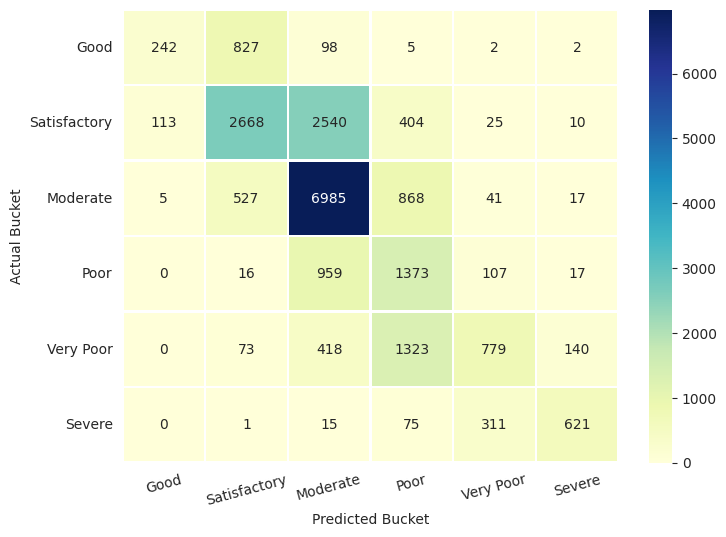

In [ ]:
plt.figure(figsize = (8,6),dpi = 100)

sns.heatmap(lr_confusion_matrix, annot = True, fmt="d", linewidths=1, cmap="YlGnBu").\
set(xlabel="Predicted Bucket", ylabel="Actual Bucket")

ticks_labels = ["Good", "Satisfactory", "Moderate", "Poor", "Very Poor", "Severe"]
plt.xticks(np.arange(6) + .5, labels=ticks_labels)
plt.yticks(np.arange(6) + .5, labels=ticks_labels)

plt.xticks(rotation = 15)
plt.yticks(rotation = 0)
plt.show()

When grouping the predictions into different buckets, we can again see that the model is able to capture the main trend of the AQI index. The predicted bucket is generally very close to the actual bucket.

## Model 2: Gradient Boosting Regression

### Implementation

We use gradient boosting ensemble to train our data.

The hyperparameters we are tuning are the the number of boosting stages to perform (n_estimators) and alpha. A large number of n_estimators usually can result in a better performance

In [ ]:
# Takes ~2min to run
gb_model = ensemble.GradientBoostingRegressor(
    n_estimators= 500,
    alpha = 0.001,
    random_state = 1,
    verbose = True
).fit(x_train_scaled, y_train)

      Iter       Train Loss   Remaining Time 
         1       13452.3704            2.86m
         2       11938.4114            2.83m
         3       10615.5307            2.84m
         4        9541.1706            2.84m
         5        8608.6953            2.81m
         6        7868.8345            2.80m
         7        7169.7172            2.81m
         8        6582.5001            2.79m
         9        6086.8904            2.78m
        10        5676.1581            2.77m
        20        3454.1939            2.65m
        30        2767.5815            2.58m
        40        2471.5619            2.53m
        50        2310.1766            2.48m
        60        2224.9699            2.42m
        70        2147.3427            2.36m
        80        2101.3151            2.31m
        90        2053.9251            2.25m
       100        2016.9208            2.20m
       200        1780.9708            1.90m
       300        1651.0803            1.22m
       40

By performing the boosting 500 times, we get a fairly good model. The train loss passes the elbow and drops to 1502.

### Evaluation

In [ ]:
test_pred_gb = gb_model.predict(x_test_scaled)
gb_R2 = metrics.r2_score(y_test, test_pred_gb)
gb_MAE = metrics.mean_absolute_error(y_test, test_pred_gb)
gb_MSS = metrics.mean_squared_error(y_test, test_pred_gb)  

print ("The R^2 score is {}".format(round(gb_R2,3)))
print ("The MAE  is {}".format(round(gb_MAE,3)))
print ("the MSS is {}".format(round(gb_MSS,3)))

The R^2 score is 0.879
The MAE  is 23.703
the MSS is 1827.533


The R^2 score is much higher than the linear regression. The MAE and MSS are lower.

The most import feature in making prediction is PM2.5, followed by PM10 and CO.

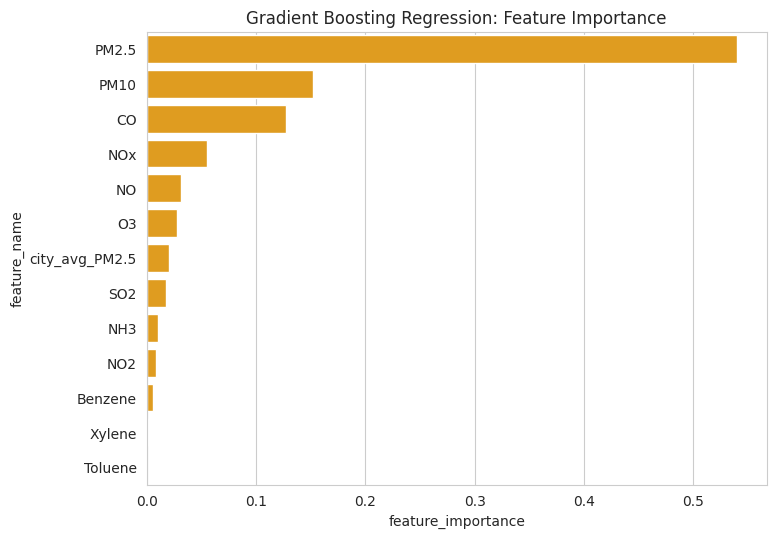

In [ ]:
gb_feature_importance = pd.DataFrame({"feature_name": x_train.columns, 
                                      "feature_importance": gb_model.feature_importances_}).\
                                      sort_values(by = ["feature_importance"], ascending = False)

plt.figure(figsize = (8,6),dpi = 100)
# sns.color_palette("tab10")
sns.barplot(data = gb_feature_importance, 
                x = "feature_importance", y = "feature_name", color = "orange").\
set(title = "Gradient Boosting Regression: Feature Importance")
plt.show()

We can also plot the SHAP (Shapley Additive exPlanations) value for each feature. This is a quantitative measure of how much contribution each variable brings to predicting the AQI index.

In [ ]:
!pip install shap==0.40.0

     |████████████████████████████████| 564 kB 7.6 MB/s 


In [ ]:
import shap
shap.initjs()

 99%|===================| 9885/10000 [01:30<00:01]       

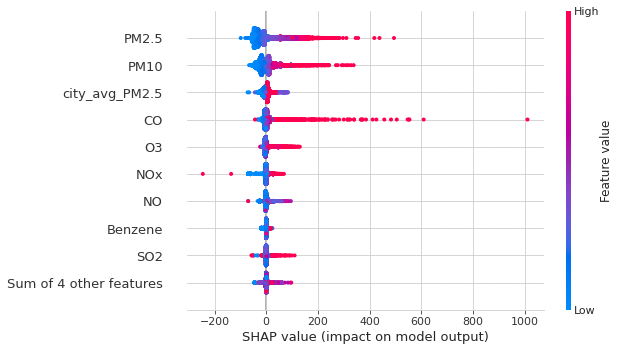

In [ ]:
small_df = pd.DataFrame(x_train_scaled[:10000])
small_df.columns = x_train.columns

explainer = shap.Explainer(gb_model, small_df)

shap_values = explainer(small_df)
shap.plots.beeswarm(shap_values)

Again, PM2.5, PM10, CO turn out to be important. High values of these three metrics are associated with high AQI Index.

## Model 3: Neural Network

### Implementation

We specify three hidden layers in our MLP Regressor Model. The number neurons are specified to be 16, 32, 32, respectively. The activation function is chosen to be Relu. To avoid overfitting, we enable the early_stopping option. This means that the training will be forced stop if we do not see any more improvement in the validation score in 10 consecutive training rounds.

In [ ]:
mlp_model = MLPRegressor(hidden_layer_sizes=(16,32,32),
                         activation = "relu",
                         random_state = 1, 
                         max_iter = 200,
                         early_stopping = True,
                         verbose = True).fit(x_train_scaled, y_train)

Iteration 1, loss = 8899.60146342
Validation score: 0.609809
Iteration 2, loss = 2635.45955826
Validation score: 0.687816
Iteration 3, loss = 2247.57252889
Validation score: 0.723263
Iteration 4, loss = 1967.38880157
Validation score: 0.750374
Iteration 5, loss = 1818.10204407
Validation score: 0.757619
Iteration 6, loss = 1730.12832616
Validation score: 0.775069
Iteration 7, loss = 1667.52431286
Validation score: 0.783644
Iteration 8, loss = 1623.87062095
Validation score: 0.786283
Iteration 9, loss = 1588.75064070
Validation score: 0.792059
Iteration 10, loss = 1556.26620195
Validation score: 0.793170
Iteration 11, loss = 1540.39699462
Validation score: 0.798520
Iteration 12, loss = 1516.20460492
Validation score: 0.799641
Iteration 13, loss = 1493.92539812
Validation score: 0.803303
Iteration 14, loss = 1475.17132101
Validation score: 0.805086
Iteration 15, loss = 1452.71164688
Validation score: 0.807909
Iteration 16, loss = 1431.62811462
Validation score: 0.810868
Iteration 17, los

### Evaluation

In [ ]:
y_pred_mlp = mlp_model.predict(x_test_scaled)

mlp_R2 = metrics.r2_score(y_test, y_pred_mlp)
mlp_MAE = metrics.mean_absolute_error(y_test, y_pred_mlp)
mlp_MSS = metrics.mean_squared_error(y_test, y_pred_mlp)  

print ("The R^2 score is {}".format(round(mlp_R2,3)))
print ("The MAE  is {}".format(round(mlp_MAE,3)))
print ("the MSS is {}".format(round(mlp_MSS,3)))

The R^2 score is 0.862
The MAE  is 25.224
the MSS is 2073.869


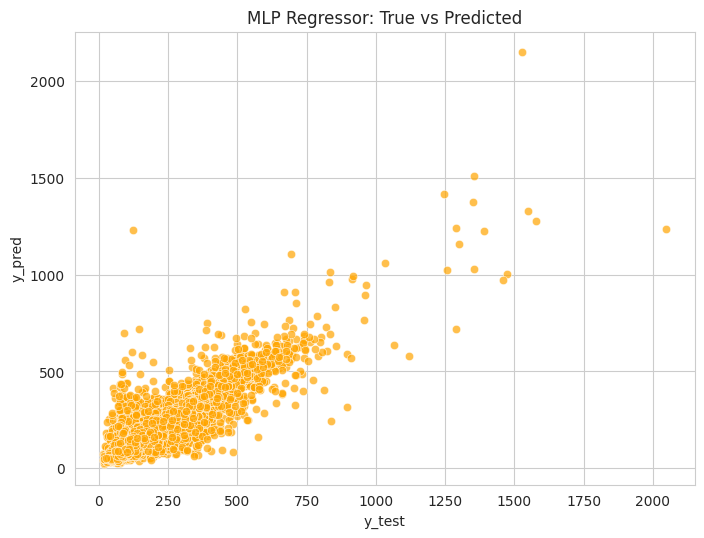

In [ ]:
mlp_df = pd.DataFrame({"y_pred":y_pred_mlp, "y_test": y_test.values})
plt.figure(figsize = (8,6),dpi = 100)
sns.color_palette("tab10")
sns.scatterplot(data = mlp_df, x = "y_test", y = "y_pred", alpha = 0.7, color = "orange").\
set(title = "MLP Regressor: True vs Predicted")
plt.show()

The decreasing rate of loss dramatically slows down after 6 iterations, and starts to level off at around 100 iterations. 

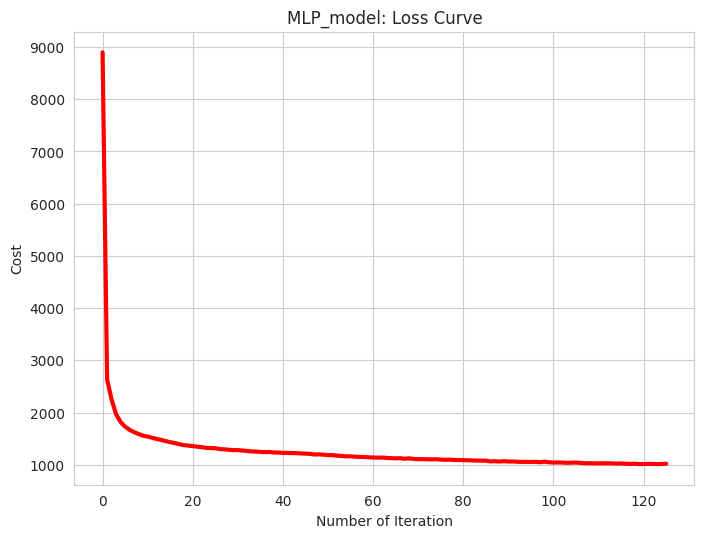

In [ ]:
plt.figure(figsize = (8,6),dpi = 100)

plt.plot(mlp_model.loss_curve_, color = "red", lw = 3)
plt.title("MLP_model: Loss Curve")
plt.ylabel('Cost')
plt.xlabel('Number of Iteration')
plt.show()

## Model 4: SARIMA Time Series Prediction Model

In the EDA part, we aggregate the station-level data by date, obtaining the average AQI index of Index on each day, and plotted the time series data. We noticed there are clear trend and seasonality in our data. Enlighted by this preliminary finding, we will use the Seasonal Autoregressive Integrated Moving Average (SARIMA) to build a time series model to forecast AQI.

In this part, we will use the data of city Delhi from city_day dataframe. Delhi is the second most polluted city in our dataset, and data of Delhi covers date from 2015-01-01 to 2020-07-01. 

In [ ]:
city_day['Date'] = pd.to_datetime(city_day['Date'])
Delhi_timeseries = city_day.loc[city_day['City'] == 'Delhi',['Date','AQI']].set_index('Date')

We first visualize the time series data of Delhi to get an overview. We can see there are trend and seasonality in our dataset.

(array([-100.,    0.,  100.,  200.,  300.,  400.,  500.,  600.,  700.,
         800.]), <a list of 10 Text major ticklabel objects>)

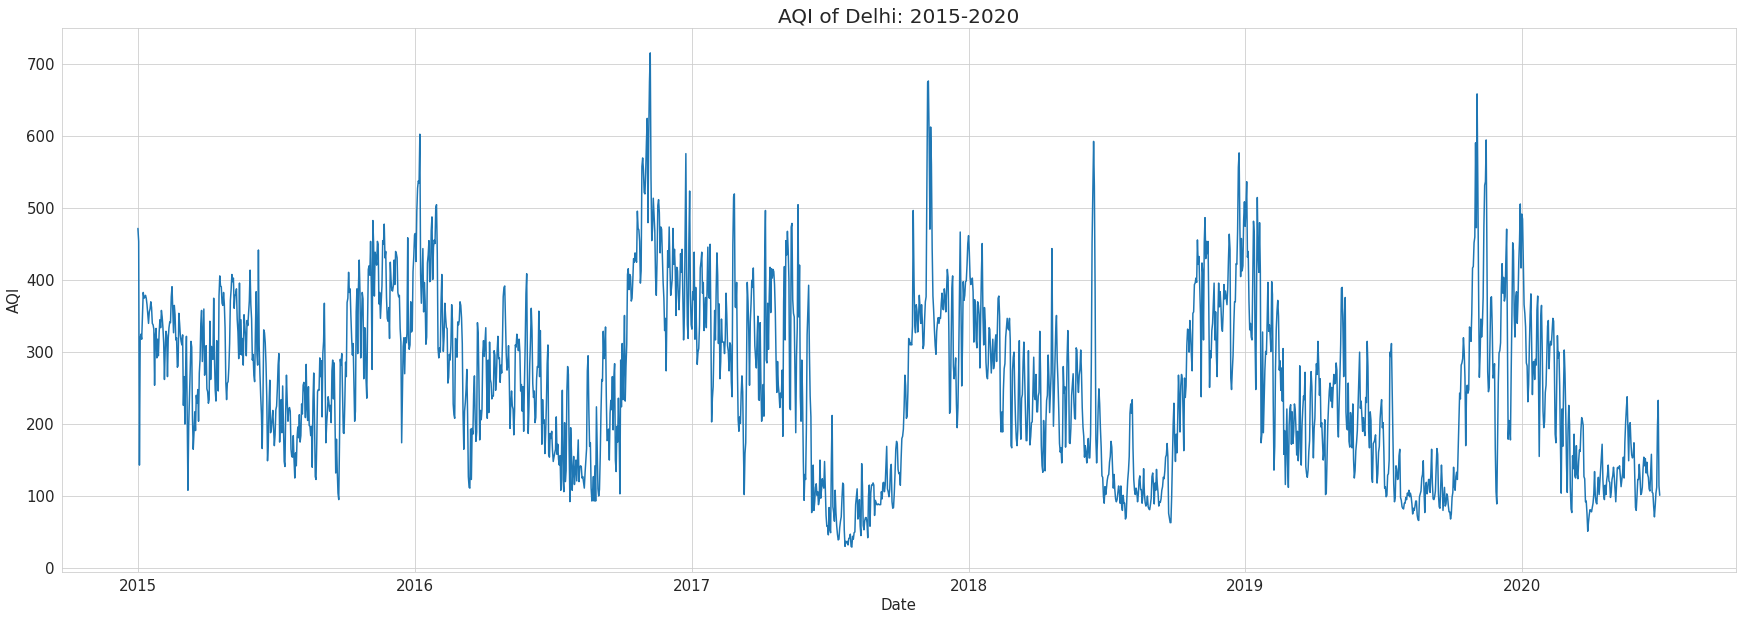

In [ ]:
fig = plt.figure(figsize = (30,10))
ax = sns.lineplot(data=Delhi_timeseries['AQI'])
ax.set_title("AQI of Delhi: 2015-2020", fontsize = 20)
ax.set_xlabel("Date", fontsize = 15)
ax.set_ylabel("AQI", fontsize = 15)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)

In terms of air quality, *week* is a nice unit to capture the change of air quality within a year while smoothing out the turbulence within a week. So we aggregate the data by week.

In [ ]:
Delhi_timeseries['week'] = Delhi_timeseries.index.week
Delhi_timeseries['year'] = Delhi_timeseries.index.year
Delhi_week = Delhi_timeseries.groupby(['year','week']).mean().reset_index()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  """Entry point for launching an IPython kernel.


Store the year that corresponds to the index

In [ ]:
x_ticks = {}
for x in range(2015,2021):
  x_ticks[Delhi_week[Delhi_week['year']==x].index.min()] = x

###Time Series Data Decomposition

First we break down the time series data to examine its trend, seasonality, and noise.

In [ ]:
Decomp = seasonal_decompose(Delhi_week['AQI'],freq=52)
Delhi_decomp = Delhi_week.copy()
Delhi_decomp['trend'] = Decomp.trend
Delhi_decomp['seasonal'] = Decomp.seasonal
Delhi_decomp['resid'] = Decomp.resid

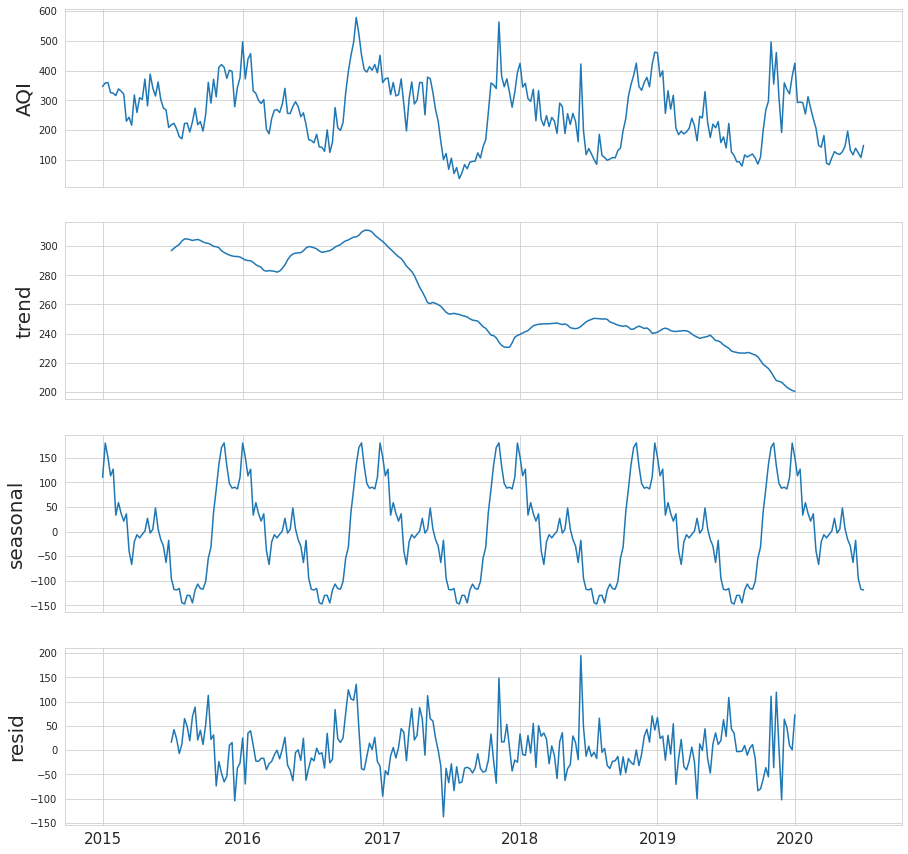

In [ ]:
fig, axs = plt.subplots(ncols=1, nrows=4, sharex=True, figsize=(15,15))
index = 0
axs = axs.flatten()
for x in ['AQI','trend','seasonal','resid']:
  ax = sns.lineplot(data=Delhi_decomp[x], ax=axs[index])
  ax.set_ylabel(str(x),fontsize=20)
  ax.set_xticks(list(x_ticks.keys()))
  ax.set_xticklabels(list(x_ticks.values()))
  plt.xticks(fontsize = 15)
  index += 1
plt.show()

We can see that this series has an overall trend of decreasing, as well as a clear seasonality which is quite constant across years. The residuals shows periods of high variability in 2017, 2018 and relatively low variablity in other years. This suggests that overall the air quality of Delhi is improving, accompanied by less volatility.

###Autocorrelation

Next, we examine the extent to which the present value is related to its past values by looking at its lagged values. We use ACF to check the autocorrelation.

<Figure size 1440x720 with 0 Axes>

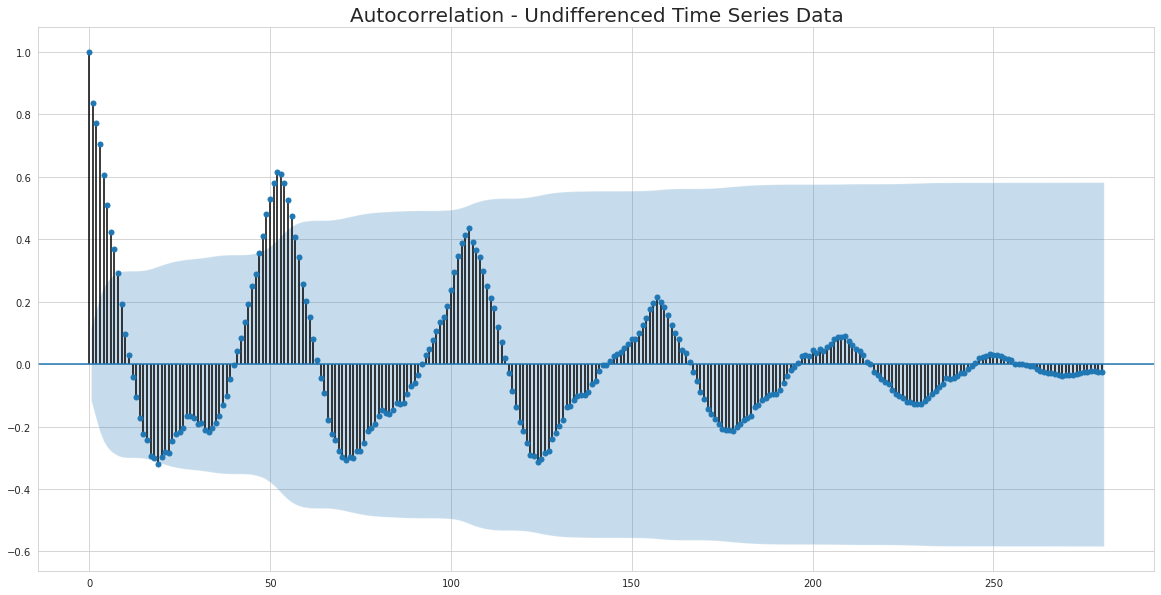

In [ ]:
plt.rc("figure", figsize=(20,10))
plt.figure(figsize=(20,10))
plot_acf(Delhi_week['AQI'], alpha = .05, lags = 280)
plt.title("Autocorrelation - Undifferenced Time Series Data", fontsize = 20)
plt.show()

Since the ACF plot does not show a quick cut off after a small number of lags, we can have an intuition that this series is not stationary. 

We can observe that there's tendency of ACF falling to 0 over time, which suggests that the older data has less impact on the new ones. By applying a confidence interval of 95%, we can notice after 8 weeks, the bar starts to fall inside the cone (on blue), which indicates that most likely this particular lag is not relevant to new values after 8 weeks.

Besides, there's also a strong trend of positive and negative correlation emerge, and a 52-month cycle, which indicates seasonal patterns. But the strength of correlation is being weakened, meaning old data are not relevant enough to carry any meaningful information.

###Differencing

To make the time series stationary, we need to utilize differencing. Here we want to eliminate trend and seasonality by non-seasonal differencing as well as seasonal differencing

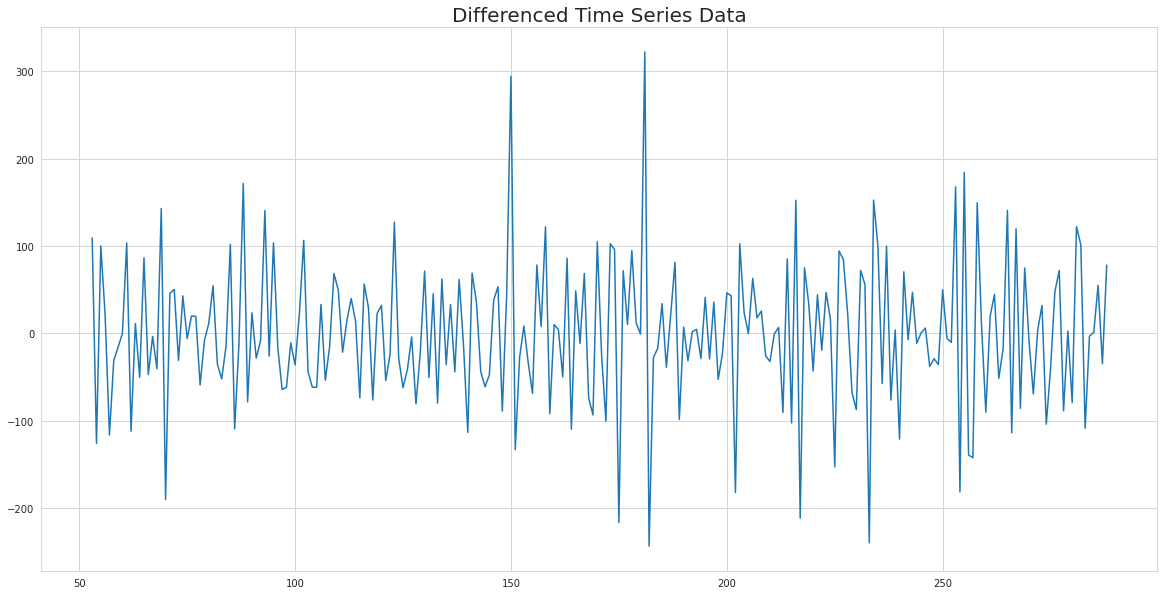

In [ ]:
diff = Delhi_week['AQI'].diff().diff(52)
diff.dropna(inplace=True)

# Plot differenced data
plt.rc("figure", figsize=(20,10))
plt.figure(figsize=(20,10))
diff.plot()
plt.title('Differenced Time Series Data', fontsize = 20)
plt.show()

<Figure size 1440x720 with 0 Axes>

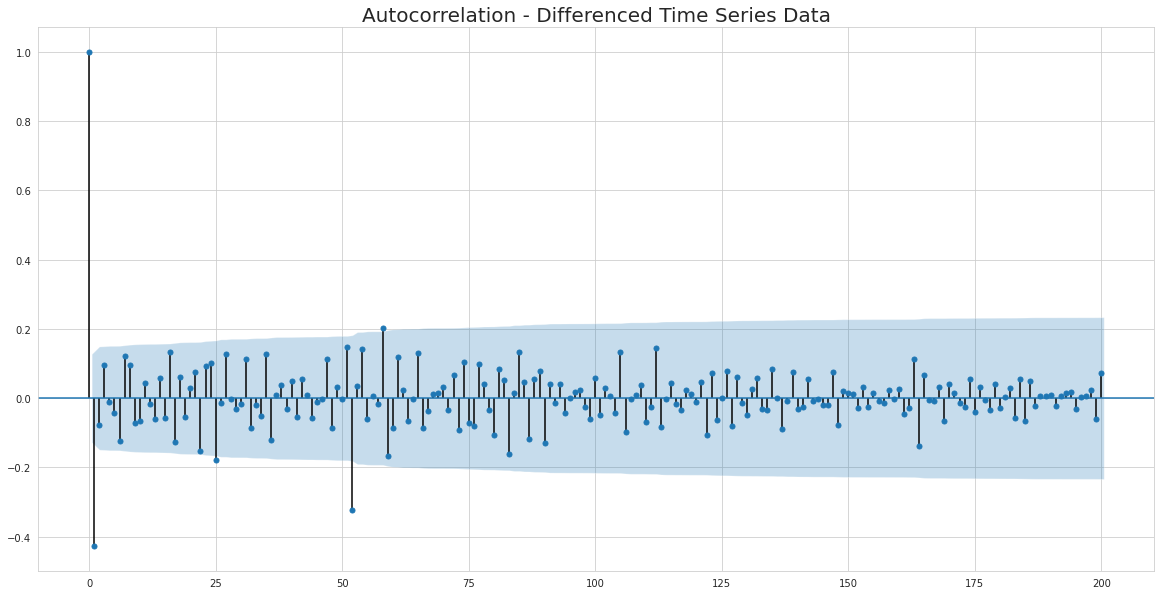

In [ ]:
plt.rc("figure", figsize=(20,10))
plt.figure(figsize=(20,10))
plot_acf(diff, lags = 200)
plt.title('Autocorrelation - Differenced Time Series Data', fontsize = 20)
plt.show()

Now we can see differenced time series data is approximately evenly distributed around 0. Combined with the auto correlation plot of the differenced data, we can tell that most of the bars fall inside the blue cone, suggesting that this series is now stationary.

###Implementation

After we have examined the dependent relationship between an value and its lagged values, the differencing order, as well as the trend and seasonality, we can build the SARIMA model.

85% of data will be used for training, and 85% of data will be used for testing.

In [ ]:
Delhi_train = Delhi_week.iloc[0:int(0.85*len(Delhi_week))].drop(columns = ['week','year'])
Delhi_test = Delhi_week.iloc[int(0.85*len(Delhi_week)):].drop(columns = ['week','year'])

Construct our SARIMA model. Hyperparameters we are using:

Order: 
AR parameters - 4;
Differences - 2;
MA parameters - 2

Seasonal order: 
AR parameter - 2;
Differences - 1;
MA parameters - 0; 
periodicity - 52 (52 weeks per year)

In [ ]:
# Train: takes about 2 mins to run
SARIMA_model = SARIMAX(Delhi_train['AQI'], order = (5, 2, 2), seasonal_order=(2,1,0,52))
SARIMA_model = SARIMA_model.fit()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:961: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


###Evaluation

In [ ]:
y_pred_ts = SARIMA_model.predict(start=Delhi_test.index.min(),end=Delhi_test.index.max())

ts_R2 = metrics.r2_score(Delhi_test['AQI'], y_pred_ts)
ts_MAE = metrics.mean_absolute_error(Delhi_test['AQI'], y_pred_ts)
ts_MSS = metrics.mean_squared_error(Delhi_test['AQI'], y_pred_ts)  

print ("The R^2 score is {}".format(round(ts_R2,3)))
print ("The MAE  is {}".format(round(ts_MAE,3)))
print ("the MSS is {}".format(round(ts_MSS,3)))

The R^2 score is 0.564
The MAE  is 59.002
the MSS is 5229.534


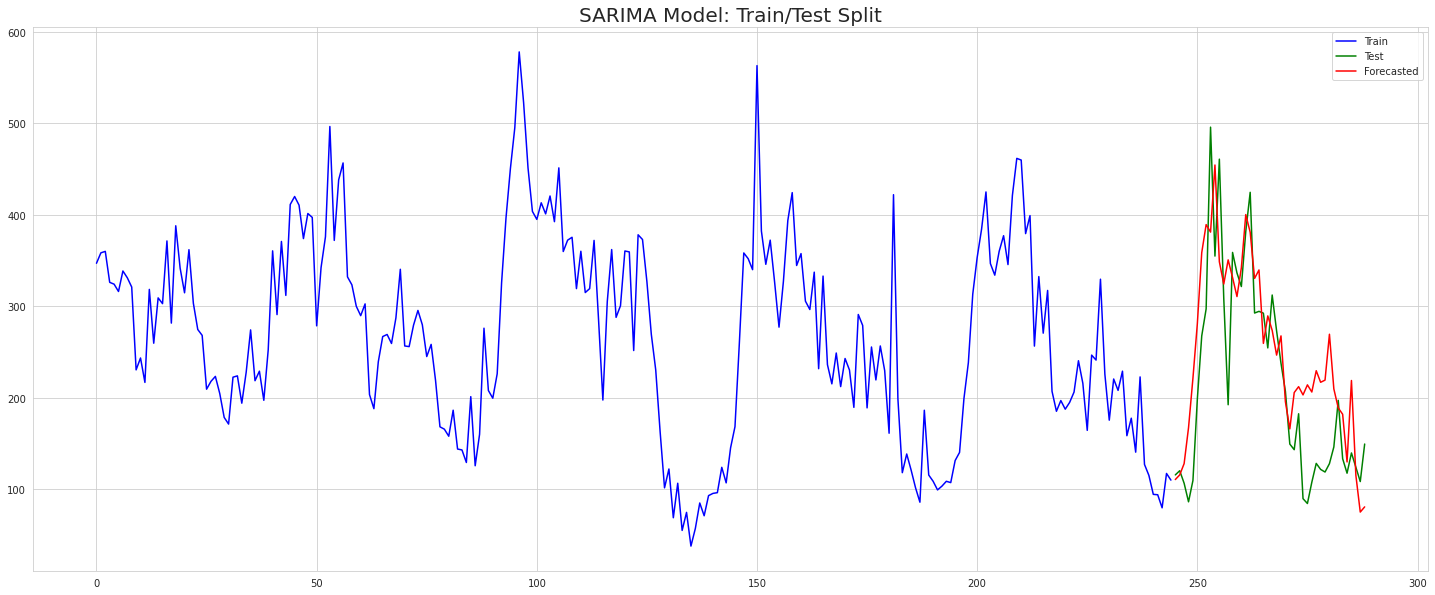

In [ ]:
# Visualize

plt.figure(figsize=(25,10))
plt.plot(Delhi_train.index, Delhi_train['AQI'], label='Train', color = 'blue')
plt.plot(Delhi_test.index, Delhi_test['AQI'], label='Test', color= 'green')
plt.plot(Delhi_test.index, y_pred_ts, label='Forecasted', color= 'red')

plt.title("SARIMA Model: Train/Test Split", fontsize = 20)
plt.legend()
plt.show()

We can see that this model can do a pretty good job in forecasting.

## Model Performance Evaluation and Comparison

In [ ]:
model_comp = pd.DataFrame({"model": ["Linear", "GB", "MLP","Time_Series:Delhi"],
                           "R2": [lr_R2, gb_R2, mlp_R2, ts_R2],
                           "MAE": [lr_MAE, gb_MAE, mlp_MAE, ts_MAE],
                           "MSS": [lr_MSS, gb_MSS, mlp_MSS, ts_MSS]})
model_comp

model        R2        MAE          MSS
0             Linear  0.682307  44.256079  4789.879855
1                 GB  0.878787  23.702851  1827.533049
2                MLP  0.862449  25.224441  2073.869077
3  Time_Series:Delhi  0.563550  59.001856  5229.534458

1. Our linear regression model achieves an R2 of 0.6823 and an MAE of 44.256. This is a simple linear regression model, which provides evidence that the features included in our model are relevant, with some room for hyperparameter tuning.
2. The best model is gradient boosting regression, with an R2 of 0.8788, and an MAE of 23.7028.
* This model is built to train trees sequentially, one at a time, and each tree will correct the errors of the previous one. So it can capture the complex pattern within the data.
* We set the n_estimators = 500, which is sufficient to correct the errors of previous trees.
3. Our neural network also has a good performance in prediction, with an R2 of 0.8624 and an MAE of 25.224 on testing data.
4. The time series forecasting for Delhi did a fairly good job in capturing the trend and seasonality, achieving an R2 of 0.5636 and an MAE of 59.002 on testing data. This is not the best model to predict AQI, but it provides some valuable insights in the pattern of AQI changes itself.



# Conclusion


---




## Findings

Throughout the project, we have come up with several findings:

1. Spatial pattern: There's a huge disparity in AQI across India. Among all the states we have collected data from, **Mizoram, Meghalaya, Kerala, and Chandigarh** have the best air quality based on averaged AQI, while **Bihar, Uttar Pradesh, Delhi and Gujarat** have the worst air quality. The gap between these regions are also widening.

2. Temporal pattern:
* Nationwide: by looking at the average AQI each date across the country, we can identify that there are a clear trend and seasonality. Overall the averaged AQI is gradually decreasing, indicating an improvement of air quality, but the votality is also increasing which suggests more variance. AQI ususally starts to rise up from around September, peaks from October to February which is mainly winter, and is ususally at its bottom in the middle of the year which is mainly summer.
* Delhi: after we specifically look into the time series data of Delhi, we noticed a similar pattern that showed across the nation.

3. Feature importance:
* We have conducted PCA, but found out that we would lose too much information if we try to reduce dimensions.
* PM2.5 appears to be the most important feature in determining AQI, both in terms of its high correlation with AQI, and its importance in the models.

## Behind the data: air quality condition in India

1. Seasonality:
* After we did research in India's air quality, we found out that contributions from stubble burning and household emissions from cooking and space heating were significant fractions of the pollution pie, which can explain why AQI started to increase dramatically from September. Harvesting seasons which starts around September could result in significant increase in the number of fires; In the following months, contribution from household emissions (including domestic cooking, space heating, water heating, and lighting) primarily drove poor air quality with the kick-in of winters.
* Space heating and stubble burning mainly contribute to the production of PM2.5, which can partly explain the importance of PM2.5 in predicting AQI.

2. Data Collection: 
* After 2018, BJP (a political party) came into power after congress. They came up with a lot of programs that ensure data collection by government agencies, which explains why we can see a significant increase in the number of cities/stations in our dataset after 2018.

3. Emissions are the main cause:
* Emissions from stubble burning, household heating, vihicles, and power plants made up the majority of the air pollutant in India. The spatial and temporal patterns we see in the analysis are deeply knitted with the emissions.

## Challenges

1. Hyperparameter tuning: We spent some time in experimenting with the parameters that can optimize the performace of our chosen model.
2. Time series forecasting: how to aggregate data. After inspecting the trend and seasonality of this time series data, we identified the seasonality period of 12 months. But our raw data is by date, which puts a high requirement on the computational ability of our computer if we we set the period/freq to 365 when training our model. So eventually we chose to aggregate our data by week, which greatly reduced the number of observations, but can still capture the differences between each observation.
3. How to combine the spatial and temporal data together.

## Potential Next Steps

1. We could continue to tune our models, to achieve better performances (potentially)

2. We could take a step further, to study which factors will have an impact on PM2.5, PM10, CO etc. We can bring in factors like meteorological data, emission data (like open fire data, stubble burning data, congestion data, power generation data).

3. We could explore models using panel data which allows us to identify 1) cross-sectional differences 2) changes over time. Hopefully we can come up with a model that can capture the spatial disparities in India, as well as the temporal patterns.

# Reference

1. Plotly Documentation: https://plotly.com/python/

2. Plotting Data Visualisation on the Map of India using GeoPandas in Python: https://shankhanilborthakur.medium.com/plotting-data-visualisation-on-the-map-of-india-using-geopandas-in-python-211bc88c1e4d

2. https://www.ceew.in/sites/default/files/ceew-study-on-controlling-delhi-air-pollution-2021_1.pdf